In [17]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np

distance = 3
num_CX_per_layer_list = [1]
num_layers = len(num_CX_per_layer_list)
assert len(num_CX_per_layer_list) ==  num_layers

print(f"num_CX_per_layer_list = {num_CX_per_layer_list}")
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
noise_params = noise_params = {'idle_loss_rate': 5.346010002745036e-08, 
                                'idle_error_rate': array([7.89314494e-09, 2.81702046e-08, 1.15650507e-07]), 
                                'entangling_zone_error_rate': array([4.50103659e-04, 5.60439308e-06, 3.29645358e-03]), 
                                'entangling_gate_error_rate': [2.393750964812938e-05, 0.00015294459572299472, 0.0016575839127290178, 2.393750964812938e-05, 0, 0, 0, 0.00015294459572299472, 0, 0, 0, 0.0016575839127290178, 0, 0, 0.00081117655901964], 
                                'entangling_gate_loss_rate': 0.0021310662492619475, 'single_qubit_error_rate': array([9.82517752e-06, 1.04167102e-03, 1.64424262e-05]), 
                                'reset_error_rate': 6.484420123608033e-05, 'measurement_error_rate': 0.002234264216316982, 'reset_loss_rate': 0.0007072757126485622,
                                'measurement_loss_rate': 0.03422498167847147, 'ancilla_idle_loss_rate': 1.569889741718561e-07, 
                                'ancilla_idle_error_rate': array([1.30972461e-07, 4.04213096e-08, 4.08181939e-06]),
                                'ancilla_reset_error_rate': 0.021408069221550766, 'ancilla_measurement_error_rate': 0.0015628602753064648, 
                                'ancilla_reset_loss_rate': 5.5115512820230125e-05, 'ancilla_measurement_loss_rate': 0.0005409239922594136,
                                'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': '0',
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': 'logical_CX', 'Steane_type': 'None', 'printing': 'True', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0', 'num_CX_per_layer_list':num_CX_per_layer_list}

noise_params = {'idle_loss_rate': 2.1462892652881424e-07, 'idle_error_rate': np.array([5.31106535e-09, 2.59649716e-08, 2.70017446e-07]), 'entangling_zone_error_rate': np.array([3.22871520e-04, 5.55115000e-06, 1.28240286e-03]), 'entangling_gate_error_rate': [1.8729598643991336e-05, 0.00016597465639499589, 0.0013401575256883555, 1.8729598643991336e-05, 0, 0, 0, 0.00016597465639499589, 0, 0, 0, 0.0013401575256883555, 0, 0, 0.0026654438378731237], 'entangling_gate_loss_rate': 0.0012268907363777474, 'single_qubit_error_rate': np.array([9.01549152e-06, 8.45064836e-04, 1.91825416e-05]), 'reset_error_rate': 0.00013112864576086654, 'measurement_error_rate': 0.003220085408683493, 'reset_loss_rate': 0.0007849977760100565, 'measurement_loss_rate': 0.06657247422436202, 'ancilla_idle_loss_rate': 1.7048289168299613e-07, 'ancilla_idle_error_rate': np.array([1.30011070e-07, 3.79578658e-08, 3.73757626e-06]), 'ancilla_reset_error_rate': 0.02267054400731952, 'ancilla_measurement_error_rate': 0.011477399332064406, 'ancilla_reset_loss_rate': 0.00014151808789913066, 'ancilla_measurement_loss_rate': 0.0004062050339110557,
                'gate_noise':LogicalCircuit.ancilla_data_differentiated_gate_noise,
            'idle_noise':LogicalCircuit.ancilla_data_differentiated_idle_noise}


simulate_data = True
num_shots = 1000
if simulate_data:
    detection_events_signs = None
    measurement_events, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, num_shots, noise_params)


else:
    # measurement_events, detection_events, observable_flips, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
    # detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)    
    # detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int) # Find detection event signs (not needed anymore)
    detection_events_signs = None
    exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                    exp_measurements[:, 1, :distance**2-1],
                                    exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 0, 2*(distance**2-1):],
                                    exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
    measurement_events = exp_measurements[:num_shots]

# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '/Users/gefenbaranes/Documents/CX_experiment'
logical_gap = True
# circuit = get_lossless_circuit(Meta_params, distance, distance, noise_params)

# DO IT
if not logical_gap:
    predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        measurement_events,
                                                                        detection_events_signs, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        logical_gaps=False,
                                                                        noise_params=noise_params, num_shots=num_shots)
    logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
    
else:
    predictions, log_probabilities, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        measurement_events,
                                                                        detection_events_signs, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        logical_gaps=True, 
                                                                        noise_params=noise_params, num_shots=num_shots)

    logical_probability = np.mean(np.logical_xor(observable_flips.flatten(), predictions[:, 0]))


print('logical error',logical_probability)


# error bar: (np.sqrt(P*(1-P)/num_shots))

num_CX_per_layer_list = [1]
logical_CX__Nlayers1__NCX1
final measurement_index = 18
logical_CX__Nlayers1__NCX1
Pauli_DEM inside the MLE_Loss_Decoder = error(0.0335644347532662729) D0
error(0.01707372961976187306) D0 D2 D4
error(0.01707372961976187306) D0 D3 D4
error(0.01707372961976187306) D1
error(0.01707372961976187306) D1 D3 D4
error(0.01707372961976187306) D2
error(0.0335644347532662729) D3
final measurement_index = 18
Preprocessing is done! it took 0.34s
0 100 200 300 400 500 600 700 800 900 Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-24
0 100 200 300 400 500 600 700 800 900 MLE decoder took 3.475127s.
logical error 0.029


In [4]:
predictions.shape

(1000, 2)

In [8]:
predictions[:,1].shape

(1000,)

In [16]:
logical_probability = np.mean(np.logical_xor(observable_flips.flatten(), predictions[:, 0]))
print('Logical error:', logical_probability)


Logical error: 0.012


In [2]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np

num_rounds = 3
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
num_CX_per_layer_list = [3, 3, 3]

noise_params = {'idle_loss_rate': 2.1462892652881424e-07, 'idle_error_rate': np.array([5.31106535e-09, 2.59649716e-08, 2.70017446e-07]), 'entangling_zone_error_rate': np.array([3.22871520e-04, 5.55115000e-06, 1.28240286e-03]), 'entangling_gate_error_rate': [1.8729598643991336e-05, 0.00016597465639499589, 0.0013401575256883555, 1.8729598643991336e-05, 0, 0, 0, 0.00016597465639499589, 0, 0, 0, 0.0013401575256883555, 0, 0, 0.0026654438378731237], 'entangling_gate_loss_rate': 0.0012268907363777474, 'single_qubit_error_rate': np.array([9.01549152e-06, 8.45064836e-04, 1.91825416e-05]), 'reset_error_rate': 0.00013112864576086654, 'measurement_error_rate': 0.003220085408683493, 'reset_loss_rate': 0.0007849977760100565, 'measurement_loss_rate': 0.06657247422436202, 'ancilla_idle_loss_rate': 1.7048289168299613e-07, 'ancilla_idle_error_rate': np.array([1.30011070e-07, 3.79578658e-08, 3.73757626e-06]), 'ancilla_reset_error_rate': 0.02267054400731952, 'ancilla_measurement_error_rate': 0.011477399332064406, 'ancilla_reset_loss_rate': 0.00014151808789913066, 'ancilla_measurement_loss_rate': 0.0004062050339110557,
                  'gate_noise':LogicalCircuit.ancilla_data_differentiated_gate_noise,
            'idle_noise':LogicalCircuit.ancilla_data_differentiated_idle_noise}
noise_params = {'idle_loss_rate': 5.346010002745036e-08,
                  'idle_error_rate': np.array([7.89314494e-09, 2.81702046e-08, 1.15650507e-07]),
                  'entangling_zone_error_rate': np.array([4.50103659e-04, 5.60439308e-06, 3.29645358e-03]),
                  'entangling_gate_error_rate': [2.393750964812938e-05, 0.00015294459572299472, 0.0016575839127290178,
                                                   2.393750964812938e-05, 0, 0, 0, 0.00015294459572299472, 0, 0, 0,
                                                   0.0016575839127290178, 0, 0, 0.00081117655901964],
                  'entangling_gate_loss_rate': 0.0021310662492619475,
                  'single_qubit_error_rate': np.array([9.82517752e-06, 1.04167102e-03, 1.64424262e-05]),
                  'reset_error_rate': 6.484420123608033e-05, 'measurement_error_rate': 0.002234264216316982,
                  'reset_loss_rate': 0.0007072757126485622, 'measurement_loss_rate': 0.03422498167847147,
                  'ancilla_idle_loss_rate': 1.569889741718561e-07,
                  'ancilla_idle_error_rate': np.array([1.30972461e-07, 4.04213096e-08, 4.08181939e-06]),
                  'ancilla_reset_error_rate': 0.021408069221550766,
                  'ancilla_measurement_error_rate': 0.0015628602753064648,
                  'ancilla_reset_loss_rate': 5.5115512820230125e-05,
                  'ancilla_measurement_loss_rate': 0.0005409239922594136,
                  'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise,
                  'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
               'bias_preserving_gates': 'False',
               'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
               'SSR': 'True', 'cycles': len(num_CX_per_layer_list)-1,
               'ordering': gate_ordering, 'circuit_index': '0',
               'decoder': 'MLE',
               'circuit_type': 'logical_CX', 'num_CX_per_layer_list': num_CX_per_layer_list,
               'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
               'loss_decoder': 'independent',
               'obs_pos': 'd-1', 'n_r': '0'}


# Load the experimental measurements
exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                 exp_measurements[:, 1, :distance**2-1],
                                 exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                 exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                 exp_measurements[:, 0, 2*(distance**2-1):],
                                 exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)

# Load the theory circuit
simulated_measurements, simulated_detection_events, simulated_observable_flips, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
# Use the theory circuit to get the detection events and observable flips corresponding to the exp data
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
# Find detection event signs
detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)

# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '.'
simulate_data = False
# DO IT
print(exp_measurements)
predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                  exp_measurements,
                                                                  detection_events_signs, use_loss_decoding,
                                                                  use_independent_decoder,
                                                                  use_independent_and_first_comb_decoder,
                                                                  logical_gaps=False,
                                                                  noise_params=noise_params)


logical_probability = np.mean(np.logical_xor(observable_flips, predictions))

print('infidelity', 1-logical_probability)

logical_CX__Nlayers3__NCX3_3_3
final measurement_index = 146
[[0 0 0 ... 0 1 0]
 [0 1 0 ... 0 2 0]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 2 1 0]
 [1 1 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]]
logical_CX__Nlayers3__NCX3_3_3
Pauli_DEM inside the MLE_Loss_Decoder = error(0.02877793606046901917) D0
error(0.008689897102474961055) D0 D3
error(0.006324350070450102633) D0 D3 D16
error(0.01202750782914281495) D0 D4
error(0.006324350070450102633) D0 D4 D14 D16
error(0.0009641219999999999825) D0 D4 D14 D38 D62
error(0.0009641219999999999825) D0 D4 D14 D62
error(0.00119432355693597776) D0 D4 D16 D38 D62
error(0.00119432355693597776) D0 D4 D16 D62
error(0.006324350070450102633) D0 D12
error(0.008387372117264965676) D0 D12 D14
error(0.002823868213805612315) D0 D12 D36 D60
error(0.001199944231680439037) D0 D12 D38 D62
error(0.002823868213805612315) D0 D12 D60
error(0.001199944231680439037) D0 D12 D62
error(0.0008111769999999999484) D0 D14 D38 D62
error(0.0008111769999999999484) D0 D14 D62
error(0.00096412199999

In [13]:
logical_probability = np.mean(np.logical_xor(observable_flips, predictions[:,0]))
print('logical error',logical_probability)


logical error 0.439456


In [7]:
observable_flips.shape

(1000, 1)

In [10]:
predictions[:,0].shape

(1000,)

### compare theory and experimental measurements:

num_CX_per_layer_list = [3, 3, 3]
logical_CX__Nlayers3__NCX3_3_3
final measurement_index = 146


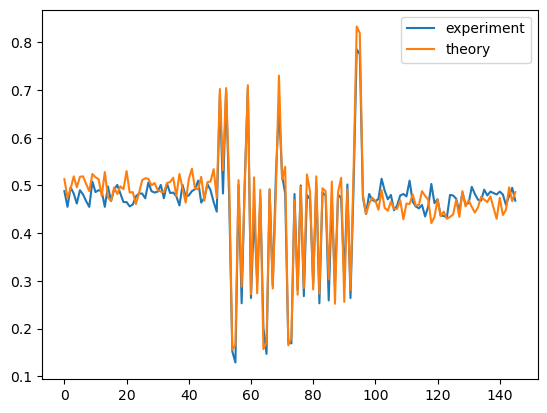

In [10]:

import matplotlib.pyplot as plt
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np
distance = 5

num_CX_per_layer_list = [3,3,3]
num_layers = len(num_CX_per_layer_list)

print(f"num_CX_per_layer_list = {num_CX_per_layer_list}")
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}



Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': '0',
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': 'logical_CX', 'Steane_type': 'None', 'printing': 'True', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0', 'num_CX_per_layer_list':num_CX_per_layer_list}


num_shots = 1000
measurement_events, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, num_shots, noise_params)
measurement_events[measurement_events == 2] = 0 #change all values in detection_events from 2 to 0

exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                    exp_measurements[:, 1, :distance**2-1],
                                    exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 0, 2*(distance**2-1):],
                                    exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
exp_measurements = exp_measurements[:num_shots]

exp_measurements[exp_measurements == 2] = 0 #change all values in detection_events from 2 to 0

plt.plot(np.average(exp_measurements,axis=0), label='experiment')

plt.plot(np.average(measurement_events,axis=0), label='theory')

plt.legend()

logical_CX__Nlayers3__NCX7_7_7
final measurement_index = 146


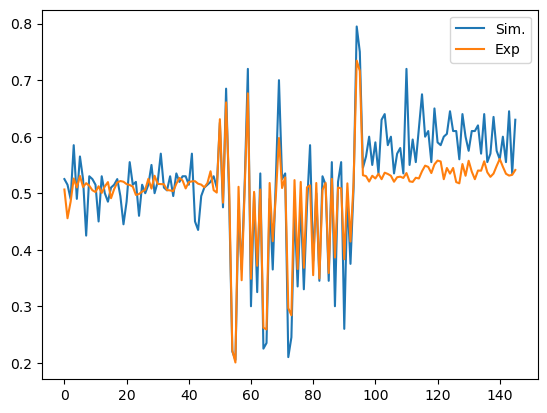

In [2]:
decoder_basis = 'XX'
# num_rounds = 3
num_CX_per_layer_list = [7,7,7]
d=5
num_rounds = len(num_CX_per_layer_list)
Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': '0',
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': 'logical_CX', 'Steane_type': 'None', 'printing': 'True', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0', 'num_CX_per_layer_list':num_CX_per_layer_list}

noise_params = {}
folder = '/Users/gefenbaranes/Documents/CX_experiment'
qubit_states_nans_perlog = np.load(f'{folder}/2024_10_16_measurement_events_7CNOT_XX.npy').transpose(1,2,0).astype(float)
qubit_states_nans_perlog[qubit_states_nans_perlog == 2.] = 1. #np.nan
qubit_states_nans_perlog[qubit_states_nans_perlog == 0.] = -1
qubit_states_nans_perlog.shape

exp_measurements = 0.5*(np.concatenate([qubit_states_nans_perlog[0, :d**2-1],
                                qubit_states_nans_perlog[1, :d**2-1],
                                qubit_states_nans_perlog[0, d**2-1:2*(d**2-1)],
                                qubit_states_nans_perlog[1, d**2-1:2*(d**2-1)],
                                qubit_states_nans_perlog[0, 2*(d**2-1):],
                                qubit_states_nans_perlog[1, 2*(d**2-1):]], axis=0)+1).T

simulated_measurement_events, simulated_detector_events, _, circuit = get_simulated_measurement_events(Meta_params, d, d, 200, noise_params = noise_params)
#detection_events_theory, observable_flips_theory = circuit.compile_m2d_converter().convert(measurements = exp_measurements.astype(bool), separate_observables = True)
#detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events_theory.astype(int), axis = 0) -1).astype(int)

#detection_events_theory = -1+2*detection_events_theory.T.astype(int)

#detector_measurements_nans = detector_measurements_nans*detection_events_signs[:,None]
#detection_events_theory = detection_events_theory*detection_events_signs_theory[:,None]

plt.plot(np.mean(simulated_measurement_events,axis = 0), label = 'Sim.')
plt.plot(np.mean(exp_measurements,axis = 0), label = 'Exp')
plt.legend()

In [3]:
np.sum(np.logical_xor(observable_flips, predictions))

4

In [4]:
num_CX_per_layer_list = [3]
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']

noise_params = {}

Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': len(num_CX_per_layer_list)-1,
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': 'logical_CX', 'num_CX_per_layer_list': num_CX_per_layer_list,
               'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0'}


simulate_data = True
num_shots = 1000
if simulate_data:
   detection_events_signs = None
   measurement_events = None



# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '/Users/gefenbaranes/Documents/CX_experiment'
# DO IT
predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                  None,
                                                                  None, use_loss_decoding,
                                                                  use_independent_decoder,
                                                                  use_independent_and_first_comb_decoder,
                                                                  simulate_data=simulate_data, logical_gaps=False,
                                                                  noise_params=noise_params, num_shots=3000)
logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
print('logical error',logical_probability)





logical_CX__Nlayers1__NCX3
final measurement_index = 18
Pauli_DEM = error(0.01193448568232855118) D0 D1
error(0.01193448568232855118) D0 D1 D2
error(0.01193448568232855118) D1 D2 D5 D6 D8
error(0.01193448568232855118) D1 D4 D5 D8
error(0.01193448568232855118) D2 D3
error(0.01193448568232855118) D2 D3 D6 D8
error(0.01193448568232855118) D4 D5
error(0.01193448568232855118) D5 D6 D7
error(0.01193448568232855292) D6 D7
final measurement_index = 18
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 

KeyboardInterrupt: 

In [1]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np



num_rounds = 1
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
num_cxs_per_rounds = [1] #[1, 3, 5, 7, 9, 11, 13, 15, 17]
#[0.96, 0.9, 0.848, 0.798, 0.742, 0.677, 0.638]
num_CX_per_layer_lists = [[i, i+1] for i in range(1, 20)]
num_CX_per_layer_lists = np.array([np.arange(3, 21, 2)]).T
num_CX_per_layer_lists = [[1]]
print(num_CX_per_layer_lists)
#raise Exception
logical_error_rates = []
for num_CX_per_layer_list in num_CX_per_layer_lists:
    noise_params = {'idle_loss_rate': 2.1462892652881424e-07, 'idle_error_rate': np.array([5.31106535e-09, 2.59649716e-08, 2.70017446e-07]), 'entangling_zone_error_rate': np.array([3.22871520e-04, 5.55115000e-06, 1.28240286e-03]), 'entangling_gate_error_rate': [1.8729598643991336e-05, 0.00016597465639499589, 0.0013401575256883555, 1.8729598643991336e-05, 0, 0, 0, 0.00016597465639499589, 0, 0, 0, 0.0013401575256883555, 0, 0, 0.0026654438378731237], 'entangling_gate_loss_rate': 0.0012268907363777474, 'single_qubit_error_rate': np.array([9.01549152e-06, 8.45064836e-04, 1.91825416e-05]), 'reset_error_rate': 0.00013112864576086654, 'measurement_error_rate': 0.003220085408683493, 'reset_loss_rate': 0.0007849977760100565, 'measurement_loss_rate': 0.06657247422436202, 'ancilla_idle_loss_rate': 1.7048289168299613e-07, 'ancilla_idle_error_rate': np.array([1.30011070e-07, 3.79578658e-08, 3.73757626e-06]), 'ancilla_reset_error_rate': 0.02267054400731952, 'ancilla_measurement_error_rate': 0.011477399332064406, 'ancilla_reset_loss_rate': 0.00014151808789913066, 'ancilla_measurement_loss_rate': 0.0004062050339110557,
                    'gate_noise':LogicalCircuit.ancilla_data_differentiated_gate_noise,
                'idle_noise':LogicalCircuit.ancilla_data_differentiated_idle_noise}
    print(num_CX_per_layer_list)
    Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                'bias_preserving_gates': 'False',
                'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                'SSR': 'True', 'cycles': len(num_CX_per_layer_list)-1,
                'ordering': gate_ordering,
                'decoder': 'MLE',
                'circuit_type': 'logical_CX', 'num_CX_per_layer_list': num_CX_per_layer_list,
                   'Steane_type': 'None', 'printing': 'True', 'num_logicals': '2',
                'loss_decoder': 'independent',
                'obs_pos': 'd-1', 'n_r': '0'}


    # Load the experimental measurements
    exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                       exp_measurements[:, 1, :distance**2-1],
                                       exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                       exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                       exp_measurements[:, 0, 2*(distance**2-1):],
                                       exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


    # Now let's decode!
    use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
    use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
    use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
    output_dir = '.'
    simulate_data = True
    # simulated_measurements, simulated_detection_events, simulated_observable_flips, circuit = get_simulated_measurement_events(
    #     Meta_params, distance, distance, 1, noise_params)
    
    circuit = get_lossless_circuit(Meta_params, distance, distance, noise_params)
    print(circuit)
    Pauli_DEM = circuit.detector_error_model(decompose_errors=False, approximate_disjoint_errors=True, ignore_decomposition_failures=True, allow_gauge_detectors=True) # GB: new Oct24, allow_gauge_detectors = True to allow DEM generation when meas basis is wrong. 
    print(f"DEM from the lossless circuit: {Pauli_DEM}")
    
    print("NOW DECODING")
    #raise Exception
    # DO IT
    predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        None,
                                                                        None, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        simulate_data=simulate_data, logical_gaps=False,
                                                                        noise_params=noise_params, num_shots=10)


    logical_probability = np.mean(np.logical_xor(observable_flips, predictions))

    print('fidelity', 1-logical_probability)
    logical_error_rates.append(1-logical_probability)

    print('all_fidelities', logical_error_rates)

[[1]]
[1]
logical_CX__Nlayers1__NCX1
R 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
X_ERROR(0.000131129) 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
I 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 2 4 6 13 15 22 24 26 33 35 42 44 46
R 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
X_ERROR(0.000131129) 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
I 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
SQRT_Y 52 54 61 63 65 72 74 81 83 85 92 94
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 52 54 61 63 65 72 74 81 83 85 92 94
SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95
PAULI_CHANNEL_1(9.01549e-06, 0.000

In [1]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np



num_rounds = 3
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
num_cxs_per_rounds = [1, 3]
num_shots = 10

logical_error_rates = []
for num_cxs_per_round in num_cxs_per_rounds:
    num_CX_per_layer_list = [num_cxs_per_round,num_cxs_per_round,num_cxs_per_round]
    for distance in [3,5]:
        print(f"distance = {distance}")
        print(f"num_CX_per_layer_list = {num_CX_per_layer_list}")
        noise_params = {'idle_loss_rate': 2.1462892652881424e-07, 'idle_error_rate': np.array([5.31106535e-09, 2.59649716e-08, 2.70017446e-07]), 'entangling_zone_error_rate': np.array([3.22871520e-04, 5.55115000e-06, 1.28240286e-03]), 'entangling_gate_error_rate': [1.8729598643991336e-05, 0.00016597465639499589, 0.0013401575256883555, 1.8729598643991336e-05, 0, 0, 0, 0.00016597465639499589, 0, 0, 0, 0.0013401575256883555, 0, 0, 0.0026654438378731237], 'entangling_gate_loss_rate': 0.0012268907363777474, 'single_qubit_error_rate': np.array([9.01549152e-06, 8.45064836e-04, 1.91825416e-05]), 'reset_error_rate': 0.00013112864576086654, 'measurement_error_rate': 0.003220085408683493, 'reset_loss_rate': 0.0007849977760100565, 'measurement_loss_rate': 0.06657247422436202, 'ancilla_idle_loss_rate': 1.7048289168299613e-07, 'ancilla_idle_error_rate': np.array([1.30011070e-07, 3.79578658e-08, 3.73757626e-06]), 'ancilla_reset_error_rate': 0.02267054400731952, 'ancilla_measurement_error_rate': 0.011477399332064406, 'ancilla_reset_loss_rate': 0.00014151808789913066, 'ancilla_measurement_loss_rate': 0.0004062050339110557,
                        'gate_noise':LogicalCircuit.ancilla_data_differentiated_gate_noise,
                    'idle_noise':LogicalCircuit.ancilla_data_differentiated_idle_noise}

        Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                    'bias_preserving_gates': 'False',
                    'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                    'SSR': 'True', 'cycles': str(num_rounds - 1),
                    'ordering': gate_ordering,
                    'decoder': 'MLE',
                    'circuit_type': f'logical_CX',
                    'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
                    'loss_decoder': 'independent',
                    'obs_pos': 'd-1', 'n_r': '0', 'num_CX_per_layer_list':num_CX_per_layer_list}


        # Load the experimental measurements
        exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
        exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                        exp_measurements[:, 1, :distance**2-1],
                                        exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                        exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                        exp_measurements[:, 0, 2*(distance**2-1):],
                                        exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
        measurement_events, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, num_shots, noise_params)
        detection_events_signs = None

        # Now let's decode!
        use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
        use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
        use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
        output_dir = '.'
        # DO IT
        predictions, log_probabilities, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        measurement_events,
                                                                        detection_events_signs, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        logical_gaps=True, 
                                                                        noise_params=noise_params, num_shots=num_shots)


        logical_probability = np.mean(np.logical_xor(observable_flips, predictions))

        print('fidelity', 1-logical_probability)
        logical_error_rates.append(1-logical_probability)

        print('all_fidelities', logical_error_rates)

distance = 3
num_CX_per_layer_list = [1, 1, 1]
logical_CX__Nlayers3__NCX1_1_1
final measurement_index = 50
logical_CX__Nlayers3__NCX1_1_1
Pauli_DEM inside the MLE_Loss_Decoder = error(0.01453929717779214002) D0
error(0.00718332878957505909) D0 D2 D6 D40
error(0.002465202426008964755) D0 D2 D40
error(0.00718332878957505909) D0 D3 D5 D6 D40
error(0.002831414999999999887) D0 D3 D5 D13 D21 D40
error(0.002831414999999999887) D0 D3 D5 D21 D40
error(0.001010783130056933663) D0 D3 D6 D13 D21 D40
error(0.001010783130056933663) D0 D3 D6 D21 D40
error(0.005213970599049886148) D0 D3 D40
error(0.00718332878957505909) D0 D4
error(0.008857923348190079385) D0 D4 D5
error(0.006330146405388720893) D0 D4 D12 D20
error(0.001015965840252101588) D0 D4 D13 D21
error(0.006330146405388720893) D0 D4 D20
error(0.001015965840252101588) D0 D4 D21
error(0.002665439999999999823) D0 D5 D13 D21
error(0.002665439999999999823) D0 D5 D21
error(0.002831414999999999887) D0 D6 D8
error(0.001018345769905341881) D0 D6 D8 D12 

In [1]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np



num_rounds = 1
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
num_cxs_per_rounds = [1, 3, 5, 7, 9, 11, 13, 15, 17]
#[0.96, 0.9, 0.848, 0.798, 0.742, 0.677, 0.638]
num_CX_per_layer_lists = [[i, i+1] for i in range(1, 20)]
num_CX_per_layer_lists = np.array([np.arange(3, 21, 2)]).T

num_CX_per_layer_lists = np.array([np.arange(3, 41, 2)]).T
#num_CX_per_layer_lists = [[i, i+1] for i in range(1, 20)]
#num_CX_per_layer_lists = [[i, i, i] for i in range(1, 17, 2)]
print(num_CX_per_layer_lists)
num_shots = 100
#raise Exception
logical_error_rates = []
num_CX_per_layer_lists = num_CX_per_layer_lists[:2]
for (index, num_CX_per_layer_list) in enumerate(num_CX_per_layer_lists):
    noise_params = {'idle_loss_rate': 2.1462892652881424e-07, 'idle_error_rate': np.array([5.31106535e-09, 2.59649716e-08, 2.70017446e-07]), 'entangling_zone_error_rate': np.array([3.22871520e-04, 5.55115000e-06, 1.28240286e-03]), 'entangling_gate_error_rate': [1.8729598643991336e-05, 0.00016597465639499589, 0.0013401575256883555, 1.8729598643991336e-05, 0, 0, 0, 0.00016597465639499589, 0, 0, 0, 0.0013401575256883555, 0, 0, 0.0026654438378731237], 'entangling_gate_loss_rate': 0.0012268907363777474, 'single_qubit_error_rate': np.array([9.01549152e-06, 8.45064836e-04, 1.91825416e-05]), 'reset_error_rate': 0.00013112864576086654, 'measurement_error_rate': 0.003220085408683493, 'reset_loss_rate': 0.0007849977760100565, 'measurement_loss_rate': 0.06657247422436202, 'ancilla_idle_loss_rate': 1.7048289168299613e-07, 'ancilla_idle_error_rate': np.array([1.30011070e-07, 3.79578658e-08, 3.73757626e-06]), 'ancilla_reset_error_rate': 0.02267054400731952, 'ancilla_measurement_error_rate': 0.011477399332064406, 'ancilla_reset_loss_rate': 0.00014151808789913066, 'ancilla_measurement_loss_rate': 0.0004062050339110557,
                    'gate_noise':LogicalCircuit.ancilla_data_differentiated_gate_noise,
                'idle_noise':LogicalCircuit.ancilla_data_differentiated_idle_noise}
    print(num_CX_per_layer_list)
    Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                'bias_preserving_gates': 'False',
                'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                'SSR': 'True', 'cycles': len(num_CX_per_layer_list)-1,
                'ordering': gate_ordering,
                'decoder': 'MLE',
                'circuit_type': 'logical_CX', 'num_CX_per_layer_list': num_CX_per_layer_list,
                   'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
                'loss_decoder': 'independent',
                'obs_pos': 'd-1', 'n_r': '0'}


    # Load the experimental measurements
    # exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
    # exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
    #                                 exp_measurements[:, 1, :distance**2-1],
    #                                 exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
    #                                 exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
    #                                 exp_measurements[:, 0, 2*(distance**2-1):],
    #                                 exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)

    simulated_measurement_events, simulated_detector_events, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, num_shots, noise_params = noise_params)

    # Now let's decode!
    use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
    use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
    use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
    output_dir = '.'
    #print(circuit)
    #print(circuit.detector_error_model(approximate_disjoint_errors=True))
    #circuit.logical_qubits[1].visualize_code()
    #raise Exception
    #raise Exception
    # DO IT
    predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        simulated_measurement_events,
                                                                        None, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        logical_gaps=False,
                                                                        noise_params=noise_params, num_shots=num_shots)

    """np.save('predictions_{}_{}'.format(3, index), predictions)
    np.save('log_probabilities_{}_{}'.format(3, index), log_probabilities)
    np.save('observable_flips_{}_{}'.format(3, index), observable_flips)"""
    logical_probability = np.mean(np.logical_xor(observable_flips.flatten(), predictions.flatten()))

    print('fidelity', 1-logical_probability)
    logical_error_rates.append(1-logical_probability)

    print('all_fidelities', logical_error_rates)


[[ 3]
 [ 5]
 [ 7]
 [ 9]
 [11]
 [13]
 [15]
 [17]
 [19]
 [21]
 [23]
 [25]
 [27]
 [29]
 [31]
 [33]
 [35]
 [37]
 [39]]
[3]
logical_CX__Nlayers1__NCX3
final measurement_index = 50
logical_CX__Nlayers1__NCX3
Pauli_DEM inside the MLE_Loss_Decoder = error(0.04791151666368750894) D0
error(0.02455889779263274383) D0 D3
error(0.02455889779263274383) D0 D4
error(0.04791151666368750894) D1
error(0.02455889779263274383) D1 D4
error(0.02455889779263274383) D1 D5
error(0.02455889779263274383) D2
error(0.02455889779263274383) D2 D5
error(0.02455889779263274383) D3 D6 D12
error(0.02455889779263274383) D4 D6 D12
error(0.02455889779263274383) D4 D7 D12
error(0.02455889779263274383) D5 D7 D12
error(0.02455889779263274383) D5 D8 D12
error(0.02455889779263274383) D6 D9
error(0.02455889779263274383) D6 D10
error(0.02455889779263274383) D7 D10
error(0.02455889779263274383) D7 D11
error(0.02455889779263274383) D8 D11
error(0.02455889779263274383) D9
error(0.04791151666368750894) D10
error(0.04791151666368750894

In [1]:
# from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
# import numpy as np



# num_rounds = 1
# distance = 5
# decoder_basis = 'XX'
# gate_ordering = ['N', 'Z']
# num_cxs_per_rounds = [1, 3, 5, 7, 9, 11, 13, 15, 17]
# #[0.96, 0.9, 0.848, 0.798, 0.742, 0.677, 0.638]
# num_CX_per_layer_lists = [[i, i+1] for i in range(1, 20)]
# num_CX_per_layer_lists = np.array([np.arange(3, 21, 2)]).T
# print(num_CX_per_layer_lists)
# num_CX_per_layer_lists = [[5]]
# #raise Exception
# logical_error_rates = []
# for num_CX_per_layer_list in num_CX_per_layer_lists:
#     noise_params = {'idle_loss_rate': 2.1462892652881424e-07, 'idle_error_rate': np.array([5.31106535e-09, 2.59649716e-08, 2.70017446e-07]), 'entangling_zone_error_rate': np.array([3.22871520e-04, 5.55115000e-06, 1.28240286e-03]), 'entangling_gate_error_rate': [1.8729598643991336e-05, 0.00016597465639499589, 0.0013401575256883555, 1.8729598643991336e-05, 0, 0, 0, 0.00016597465639499589, 0, 0, 0, 0.0013401575256883555, 0, 0, 0.0026654438378731237], 'entangling_gate_loss_rate': 0.0012268907363777474, 'single_qubit_error_rate': np.array([9.01549152e-06, 8.45064836e-04, 1.91825416e-05]), 'reset_error_rate': 0.00013112864576086654, 'measurement_error_rate': 0.003220085408683493, 'reset_loss_rate': 0.0007849977760100565, 'measurement_loss_rate': 0.06657247422436202, 'ancilla_idle_loss_rate': 1.7048289168299613e-07, 'ancilla_idle_error_rate': np.array([1.30011070e-07, 3.79578658e-08, 3.73757626e-06]), 'ancilla_reset_error_rate': 0.02267054400731952, 'ancilla_measurement_error_rate': 0.011477399332064406, 'ancilla_reset_loss_rate': 0.00014151808789913066, 'ancilla_measurement_loss_rate': 0.0004062050339110557,
#                     'gate_noise':LogicalCircuit.ancilla_data_differentiated_gate_noise,
#                 'idle_noise':LogicalCircuit.ancilla_data_differentiated_idle_noise}
#     print(num_CX_per_layer_list)
#     Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
#                 'bias_preserving_gates': 'False',
#                 'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
#                 'SSR': 'True', 'cycles': len(num_CX_per_layer_list)-1,
#                 'ordering': gate_ordering,
#                 'decoder': 'MLE',
#                 'circuit_type': 'logical_CX', 'num_CX_per_layer_list': num_CX_per_layer_list,
#                 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
#                 'loss_decoder': 'independent',
#                 'obs_pos': 'd-1', 'n_r': '0'}


#     # Load the experimental measurements
#     exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
#     exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
#                                     exp_measurements[:, 1, :distance**2-1],
#                                     exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
#                                     exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
#                                     exp_measurements[:, 0, 2*(distance**2-1):],
#                                     exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


#     # Now let's decode!
#     use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
#     use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
#     use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
#     output_dir = '.'
#     simulate_data = True
#     circuit = get_lossless_circuit(Meta_params, distance, distance, noise_params)
#     print(circuit.detector_error_model(approximate_disjoint_errors=True))
#     #raise Exception
#     #raise Exception
#     # DO IT
#     predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
#                                                                         None,
#                                                                         None, use_loss_decoding,
#                                                                         use_independent_decoder,
#                                                                         use_independent_and_first_comb_decoder,
#                                                                         simulate_data=simulate_data, logical_gaps=False,
#                                                                         noise_params=noise_params, num_shots=10)


#     logical_probability = np.mean(np.logical_xor(observable_flips, predictions))

#     print('fidelity', 1-logical_probability)
#     logical_error_rates.append(1-logical_probability)

#     print('all_fidelities', logical_error_rates)

[[ 3]
 [ 5]
 [ 7]
 [ 9]
 [11]
 [13]
 [15]
 [17]
 [19]]
[5]
logical_CX__Nlayers1__NCX5
error(0.05979961699394466951) D0
error(0.0308516316739152717) D0 D3
error(0.0308516316739152717) D0 D4
error(0.05979961699394466951) D1
error(0.0308516316739152717) D1 D4
error(0.0308516316739152717) D1 D5
error(0.0308516316739152717) D2
error(0.0308516316739152717) D2 D5
error(0.0308516316739152717) D3 D6 L0
error(0.0308516316739152717) D4 D6 L0
error(0.0308516316739152717) D4 D7 L0
error(0.0308516316739152717) D5 D7 L0
error(0.0308516316739152717) D5 D8 L0
error(0.0308516316739152717) D6 D9
error(0.0308516316739152717) D6 D10
error(0.0308516316739152717) D7 D10
error(0.0308516316739152717) D7 D11
error(0.0308516316739152717) D8 D11
error(0.0308516316739152717) D9
error(0.05979961699394466951) D10
error(0.05979961699394466951) D11
logical_CX__Nlayers1__NCX5
final measurement_index = 50
Pauli_DEM inside the MLE_Loss_Decoder = error(0.05979962731993435782) D0
error(0.03085163717643346973) D0 D3
error(0

IndexError: index 13 is out of bounds for axis 0 with size 13

In [3]:
print(circuit)

R 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
X_ERROR(0.000131129) 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
I 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 2 4 6 13 15 22 24 26 33 35 42 44 46
R 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
X_ERROR(0.000131129) 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
I 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
SQRT_Y 52 54 61 63 65 72 74 81 83 85 92 94
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 52 54 61 63 65 72 74 81 83 85 92 94
SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95
PAULI_CHANNEL_1(9.01549e-06, 0.000845065, 1.91825e-05) 51 53 55 62 64 7

In [32]:
measurement_events

array([[1, 1, 1, ..., 0, 0, 2],
       [0, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 1, ..., 2, 0, 1],
       [1, 1, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 1, 0, 1]])

In [37]:
# theory measu events out:
observable_flips.shape
predictions.shape
# 1 - logical error 0.085

(200, 1)

In [40]:
## all theory:
observable_flips.shape
predictions.shape
# 1 - logical error 0.105

(200, 1)

In [48]:
### experiment:
observable_flips.shape
predictions.shape
logical_probability = np.mean(np.logical_xor(observable_flips.astype(int), predictions.astype(int)))
logical_probability
# observable_flips.astype(int)
# predictions
# 1 - logical error 0.815

0.815

In [31]:
# theory:
np.sum(measurement_events,axis=1)
# 1 - logical error 0.096

array([ 93,  77,  80,  74,  71,  65,  87,  79,  87,  86,  71,  73,  67,
        76,  68,  82,  72,  70,  86,  61,  76,  80,  91,  88,  77,  80,
        87,  68,  75,  71,  78,  84,  72,  80,  81,  74,  87,  72,  68,
        70,  81,  75,  90,  83,  85,  66,  80,  77,  75,  70,  68,  80,
        78,  73,  77,  83,  74,  72,  86,  78,  66,  75,  83,  69,  81,
        80,  66,  76,  73,  72,  76,  76,  80,  70,  65,  81,  77,  80,
        79,  82,  74,  86,  74,  71,  73,  78,  71,  74,  87,  77,  69,
        83,  79,  87,  68,  82,  75,  66,  78,  80,  70,  72,  78,  69,
        74,  83,  66,  79,  78,  60,  73,  74,  82,  79,  75,  85,  84,
        77,  79,  67,  73,  85,  80,  80,  74,  79,  82,  79,  79,  72,
        89,  73,  76,  82,  93,  74,  69,  77,  84,  81,  73,  80,  83,
        82,  92,  77,  90,  64,  98,  79,  88,  80,  88,  64,  77,  73,
        85,  81,  87,  67,  63,  86,  83,  72,  76,  74,  85,  74,  76,
        78,  81,  72,  90,  76,  71,  85,  72,  66,  74,  86,  8

In [29]:
# experiment:
np.sum(measurement_events,axis=1)

array([72, 66, 75, 84, 78, 84, 65, 87, 79, 90, 76, 80, 77, 89, 73, 72, 76,
       73, 88, 71, 71, 77, 93, 68, 76, 74, 75, 75, 72, 67, 75, 90, 82, 77,
       88, 83, 80, 75, 76, 77, 89, 80, 72, 86, 84, 84, 83, 85, 88, 80, 84,
       70, 70, 83, 70, 72, 75, 85, 85, 79, 95, 80, 74, 82, 72, 76, 83, 79,
       78, 77, 81, 61, 91, 71, 77, 76, 77, 64, 68, 85, 87, 73, 86, 71, 84,
       77, 74, 77, 80, 77, 89, 64, 74, 72, 73, 74, 78, 74, 70, 76, 62, 70,
       85, 82, 78, 93, 84, 75, 80, 78, 79, 79, 79, 70, 84, 70, 70, 69, 88,
       83, 81, 67, 77, 73, 76, 83, 81, 76, 66, 82, 79, 73, 74, 79, 80, 74,
       77, 69, 79, 81, 79, 79, 91, 75, 82, 87, 75, 74, 80, 85, 91, 83, 70,
       90, 89, 70, 90, 83, 87, 75, 75, 87, 73, 85, 74, 85, 83, 84, 82, 66,
       74, 72, 71, 72, 95, 65, 76, 77, 84, 77, 67, 69, 78, 71, 66, 81, 69,
       82, 69, 80, 88, 93, 86, 75, 77, 74, 86, 73, 80, 87, 79, 76, 82, 82,
       65, 69, 74, 74, 77, 74, 71, 84, 81, 79, 77, 69, 79, 85, 73, 69, 87,
       79, 82, 89, 86, 69

In [5]:
exp_measurements

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 1, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [11]:
exp_measurements[:10].shape

(10, 146)

In [12]:
sum(exp_measurements[:10])

array([ 5,  8,  3,  6,  5,  4,  6,  5,  6,  8,  8,  2,  8,  6, 10,  6,  4,
        5,  3,  4,  2,  6,  7,  5,  5,  3,  4,  5,  6,  3,  6,  7,  8,  6,
        8,  2,  7,  7, 11,  6,  7,  5,  4,  6,  2,  5,  5,  8,  4,  5,  8,
        6,  8,  4,  1,  1,  3,  3,  5,  9,  3,  5,  2,  5,  3,  4,  2,  1,
        8,  7,  6,  7,  3,  2,  7,  4,  3,  5,  6,  5,  4,  7,  3,  7,  7,
        3,  6,  3,  2,  5,  5,  5,  3,  4,  8,  8,  4,  6,  7,  7,  5,  4,
        3,  5,  4,  7,  5,  8,  4,  5,  4,  6,  2,  5,  4,  6,  7,  7,  6,
        5,  8,  7,  7,  4,  5,  5,  2,  6,  6,  5,  8,  6,  8,  4,  4,  6,
        3,  8,  6,  5, 11,  9,  7,  6,  8,  7])

In [7]:
1-logical_probability

0.894

In [5]:
logical_probability

0.8510911424903723

In [3]:
print('/n 1 - logical error',1- logical_probability)


/n 1 - logical error 0.14890885750962768


In [6]:
x = 4
num_CX_per_layer = 2*x + 1
for cx_ix in range(num_CX_per_layer):
    print(cx_ix)
    if cx_ix == num_CX_per_layer // 2 : # new GB - add Y pulse on all qubits:
        print('hi')
    

0
1
2
3
4
hi
5
6
7
8


In [12]:
dict_data = {1: [1, 2], 3: [3, 4]}
qubits_to_exclude = [q for sublist in dict_data.values() for q in sublist]
print(qubits_to_exclude)


[1, 2, 3, 4]


In [14]:
import re

num_layers = 20
num_cxs_per_round = 0
circuit_type = f'logical_CX_NL{num_layers}_NCX{num_cxs_per_round}'
num_layers, num_cxs_per_round = map(int, re.findall(r'\d+', circuit_type))
print(num_layers)
print(num_cxs_per_round)

20
0


In [2]:
1-logical_probability

0.9553333333333334

In [4]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np


num_rounds = 3
num_cx = 3
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']
exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)

noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                    'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                    'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                    'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                    'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                    'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                    'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
            'bias_preserving_gates': 'False',
            'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
            'SSR': 'True', 'cycles': str(num_rounds - 1),
            'ordering': gate_ordering,
            'decoder': 'MLE',
            'circuit_type': f'logical_CX_NL{num_rounds}_NCX{num_cx}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
            'loss_decoder': 'independent',
            'obs_pos': 'd-1', 'n_r': '0'}

simulate_data = True

if simulate_data:
    detection_events_signs = None
    exp_measurements = None
    num_shots = 1000

else:
    # Load the theory circuit
    _, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
    # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
    detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
    # Find detection event signs
    detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
    exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                    exp_measurements[:, 1, :distance**2-1],
                                    exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                    exp_measurements[:, 0, 2*(distance**2-1):],
                                    exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


# Now let's decode!
use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
output_dir = '.'
# DO IT
predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                    exp_measurements,
                                                                    detection_events_signs, use_loss_decoding,
                                                                    use_independent_decoder,
                                                                    use_independent_and_first_comb_decoder,
                                                                    simulate_data=simulate_data, logical_gaps=False,
                                                                    noise_params=noise_params, num_shots=num_shots)
logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
print('/n logical error', logical_probability)

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146
0 

KeyboardInterrupt: 

In [2]:
1-0.07

0.9299999999999999

In [2]:
1-logical_probability

0.954

In [2]:
1-logical_probability

0.956

In [2]:
Meta_params['printing'] = 'False'

_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
print(circuit.num_detectors)
print("HI")
print(circuit.detector_error_model(approximate_disjoint_errors=True))

'_'

### Making a plot of results:

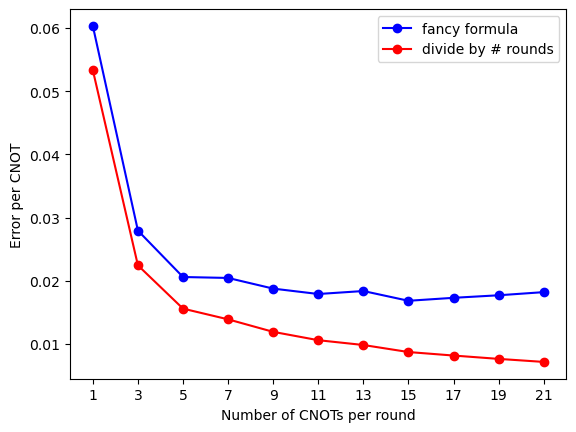

In [4]:
num_rounds = 3
num_cxs_per_round = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
logical_errors = np.array([0.16, 0.202, 0.234, 0.292, 0.322, 0.35, 0.384, 0.393, 0.4171, 0.436, 0.4517])
errors_per_rounds = .5*(1-(1-logical_errors/.5)**(1/(num_rounds*num_cxs_per_round)))
errors_per_rounds_division = logical_errors / (num_rounds*num_cxs_per_round)
plt.plot(num_cxs_per_round, errors_per_rounds, marker='o', color='blue', label='fancy formula')
plt.plot(num_cxs_per_round, errors_per_rounds_division, marker='o', color='red', label='divide by # rounds')
plt.ylabel('Error per CNOT')
plt.xlabel('Number of CNOTs per round')
plt.xticks(num_cxs_per_round)
plt.legend()
plt.show()

num_layers = 3
num_CX_per_layer = 1
final measurement_index = 146
Preprocessing is done! it took 59.61s
0 [0.025]
infidelity 0.975


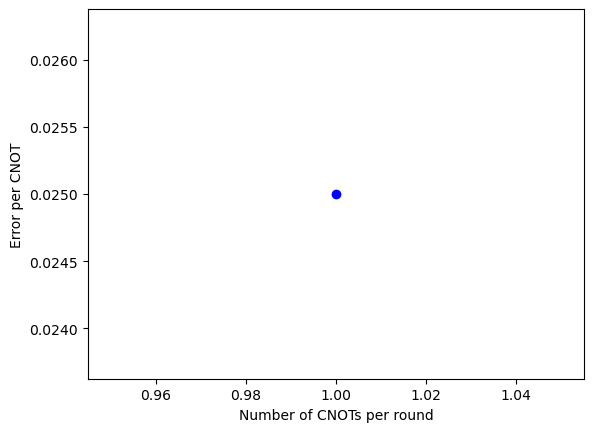

In [4]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np


num_cxs = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21])
num_cxs = np.array([1])
errors = np.array([0.16, 0.202, 0.234, 0.292, 0.322, 0.35, 0.384, 0.393, 0.4171, 0.429, 0.47])
num_rounds = 3
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']


errors = []
for num_cx in num_cxs:
    noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                    'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                    'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                    'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                    'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                    'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                    'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}

    Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                'bias_preserving_gates': 'False',
                'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                'SSR': 'True', 'cycles': str(num_rounds - 1),
                'ordering': gate_ordering,
                'decoder': 'MLE',
                'circuit_type': f'logical_CX_NL{num_rounds}_NCX{num_cx}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
                'loss_decoder': 'independent',
                'obs_pos': 'd-1', 'n_r': '0'}


    # Load the experimental measurements
    exp_measurements = np.load('2024_10_15_measurement_events_1CNOT_XX.npy')#[:100, :]
    exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                       exp_measurements[:, 1, :distance**2-1],
                                       exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                       exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                       exp_measurements[:, 0, 2*(distance**2-1):],
                                       exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)

    # Load the theory circuit
    # theory_measurements, theory_detectors, theory_observables, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1000, noise_params)
    # print(2 in theory_measurements)
    # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
    # exp_detectors, exp_observables = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
    # Find detection event signs
    # exp_detection_events_signs = -np.sign(2*np.nanmean(exp_detectors.astype(int), axis=0)-1).astype(int)

    # Now let's decode!
    use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
    use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
    use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
    output_dir = '.'
    simulate_data = True
    num_shots = 1000
    # DO IT
    """exp_predictions, exp_observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        exp_measurements,
                                                                        exp_detection_events_signs, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        simulate_data=simulate_data, logical_gaps=False,
                                                                        noise_params=noise_params)
    
    exp_logical_probability = np.mean(np.logical_xor(exp_observable_flips, exp_predictions))"""

    #print('infidelity', 1-exp_logical_probability)
    theory_predictions, theory_observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                        None,
                                                                        None, use_loss_decoding,
                                                                        use_independent_decoder,
                                                                        use_independent_and_first_comb_decoder,
                                                                        simulate_data=simulate_data, logical_gaps=False,
                                                                        noise_params=noise_params, num_shots = num_shots)

    theory_logical_probability = np.mean(np.logical_xor(theory_observable_flips, theory_predictions))
    errors.append(theory_logical_probability)
    print(errors)
    print('infidelity', 1-theory_logical_probability)


plt.plot(num_cxs, errors, marker='o', color='blue')
plt.ylabel('Error per CNOT')
plt.xlabel('Number of CNOTs per round')
plt.show()

In [2]:
## Taking data:

In [2]:
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
import numpy as np
# num_rounds = 5

P_dict = {}
P_err_dict = {}
num_shots_dict = {}
num_errors_dict = {}

num_layers_vec = [3,2]
num_cxs_per_round_vec = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
for num_layers in num_layers_vec:
    num_shots_dict[num_layers] = {}
    num_errors_dict[num_layers] = {}
    P_dict[num_layers] = {}
    P_err_dict[num_layers] = {}
    for num_cxs_per_round in num_cxs_per_round_vec:
        distance = 5
        decoder_basis = 'XX'
        gate_ordering = ['N', 'Z']
        noise_params = {'idle_loss_rate': 2.793300220405646e-07, 'idle_error_rate': np.array([6.60547942e-09, 3.38336163e-08, 2.67533789e-07]),
                        'entangling_zone_error_rate': np.array([3.66476387e-04, 6.14732819e-06, 2.35857048e-03]),
                        'entangling_gate_error_rate': [2.2260729018707513e-05, 0.00017139584089578063, 0.0012948317242757047, 2.2260729018707513e-05, 0, 0, 0, 0.00017139584089578063, 0, 0, 0, 0.0012948317242757047, 0, 0, 0.002621736717313752],
                        'entangling_gate_loss_rate': 0.00039272255674060926, 'single_qubit_error_rate': np.array([1.53681034e-05, 9.93583065e-04, 1.94650113e-05]),
                        'reset_error_rate': 5.89409983290463e-05, 'measurement_error_rate': 0.0006138700821647161, 'reset_loss_rate': 0.0007531131027610011, 'measurement_loss_rate': 0.07131074481520218, 'ancilla_idle_loss_rate': 1.6989311035347498e-07,
                        'ancilla_idle_error_rate': np.array([1.46727589e-07, 4.60893305e-08, 2.30298714e-06]), 'ancilla_reset_error_rate': 0.024549181355318986, 'ancilla_measurement_error_rate': 0.0012815874700447462, 'ancilla_reset_loss_rate': 0.00019528486460263086, 'ancilla_measurement_loss_rate': 0.00047357577582906143,
                        'gate_noise': LogicalCircuit.ancilla_data_differentiated_gate_noise, 'idle_noise': LogicalCircuit.ancilla_data_differentiated_idle_noise}



        Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
                    'bias_preserving_gates': 'False',
                    'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
                    'SSR': 'True', 'cycles': str(num_layers - 1),
                    'ordering': gate_ordering,
                    'decoder': 'MLE',
                    'circuit_type': f'logical_CX_NL{num_layers}_NCX{num_cxs_per_round}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
                    'loss_decoder': 'independent',
                    'obs_pos': 'd-1', 'n_r': '0'}



        
        simulate_data = True

        if simulate_data:
            detection_events_signs = None
            measurement_events = None
            num_shots = 5000

        else:
            # Load the experimental measurements
            exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
            exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                            exp_measurements[:, 1, :distance**2-1],
                                            exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                            exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                            exp_measurements[:, 0, 2*(distance**2-1):],
                                            exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
            measurement_events = exp_measurements
            # Load the theory circuit
            _, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
            # Use the theory circuit to get the detection events and observable flips corresponding to the exp data
            detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
            # Find detection event signs
            detection_events_signs = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)

        # Now let's decode!
        use_loss_decoding = True  # if False: use same DEM every shot, without utilizing SSR.
        use_independent_decoder = True  # if False: in every lifecycle, we just apply supercheck at the end. If True: we count the full lifecycle with different potential loss locations and corresponding Clifford propagations.
        use_independent_and_first_comb_decoder = False  # This is relevant only if use_independent_decoder=True. If False: use only independent lifecycles. If True: adds a single combination of lifecycles to the decoder.
        output_dir = '/Users/gefenbaranes/Documents/CX_experiment'
        predictions, observable_flips, dems_list = Loss_MLE_Decoder_Experiment(Meta_params, distance, distance, output_dir,
                                                                            measurement_events,
                                                                            detection_events_signs, use_loss_decoding,
                                                                            use_independent_decoder,
                                                                            use_independent_and_first_comb_decoder,
                                                                            simulate_data=simulate_data, logical_gaps=False,
                                                                            noise_params=noise_params, num_shots=num_shots)
        logical_probability = np.mean(np.logical_xor(observable_flips, predictions))
        num_errors = np.sum(np.logical_xor(observable_flips, predictions))
        logical_probability_error = (np.sqrt(logical_probability*(1-logical_probability)/num_shots))
        print(f'for num_layers = {num_layers}, num_cxs_per_round = {num_cxs_per_round} we get logical error {logical_probability} +- {logical_probability_error}\n')

        
        P_dict[num_layers][num_cxs_per_round] = logical_probability
        P_err_dict[num_layers][num_cxs_per_round] = logical_probability_error
        num_shots_dict[num_layers][num_cxs_per_round] = num_shots
        num_errors_dict[num_layers][num_cxs_per_round] = num_errors



num_layers = 3
num_CX_per_layer = 1
final measurement_index = 146
Preprocessing is done! it took 60.88s
0 1000 2000 3000 4000 for num_layers = 3, num_cxs_per_round = 1 we get logical error 0.0222 +- 0.002083610328252382

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146


KeyboardInterrupt: 

In [10]:
print(circuit.Pauli_DEM)

AttributeError: 'LogicalCircuit' object has no attribute 'Pauli_DEM'

### Compare theory to exp detection signs:

In [7]:
new_circuit_txt = """
    
R 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46
R 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
SQRT_Y 52 54 61 63 65 72 74 81 83 85 92 94
SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95
Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97




R 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

SQRT_Y 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 11 31

CZ 3 8 5 10 12 18 14 20 23 28 25 30 32 38 34 40 43 47 45 48 7 2 9 4 11 6 19 13 21 15 27 22 29 24 31 26 39 33 41 35


Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 7 9 17 19 21 27 29 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48

CZ 3 0 5 1 14 8 16 10 23 18 25 20 34 28 36 30 43 38 45 40 7 13 9 15 17 22 19 24 21 26 27 33 29 35 37 42 39 44 41 46


SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 17 37

CZ 4 8 6 10 13 18 15 20 24 28 26 30 33 38 35 40 44 47 46 48 7 3 9 5 17 12 19 14 21 16 27 23 29 25 37 32 39 34 41 36


CZ 51 49 53 50 62 57 64 59 71 67 73 69 82 77 84 79 91 87 93 89 56 61 58 63 60 65 68 72 70 74 76 81 78 83 80 85 88 92 90 94


SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 60 80

CZ 52 57 54 59 61 67 63 69 72 77 74 79 81 87 83 89 92 96 94 97 56 51 58 53 60 55 68 62 70 64 76 71 78 73 80 75 88 82 90 84


Y 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 56 58 66 68 70 76 78 86 88 90 49 50 57 59 67 69 77 79 87 89 96 97

CZ 52 49 54 50 63 57 65 59 72 67 74 69 83 77 85 79 92 87 94 89 56 62 58 64 66 71 68 73 70 75 76 82 78 84 86 91 88 93 90 95


SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 66 86

CZ 53 57 55 59 62 67 64 69 73 77 75 79 82 87 84 89 93 96 95 97 56 52 58 54 66 61 68 63 70 65 76 72 78 74 86 81 88 83 90 85


SQRT_Y_DAG 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 17 19 21 27 29 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

M 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48 49 50 56 57 58 59 60 66 67 68 69 70 76 77 78 79 80 86 87 88 89 90 96 97
DETECTOR rec[-46] rec[-22]
DETECTOR rec[-44] rec[-20]
DETECTOR rec[-42] rec[-18]
DETECTOR rec[-41] rec[-17]
DETECTOR rec[-39] rec[-15]
DETECTOR rec[-37] rec[-13]
DETECTOR rec[-36] rec[-12]
DETECTOR rec[-34] rec[-10]
DETECTOR rec[-32] rec[-8]
DETECTOR rec[-31] rec[-7]
DETECTOR rec[-29] rec[-5]
DETECTOR rec[-27] rec[-3]
DETECTOR rec[-48] rec[-24]
DETECTOR rec[-47] rec[-23]
DETECTOR rec[-45] rec[-21]
DETECTOR rec[-43] rec[-19]
DETECTOR rec[-40] rec[-16]
DETECTOR rec[-38] rec[-14]
DETECTOR rec[-35] rec[-11]
DETECTOR rec[-33] rec[-9]
DETECTOR rec[-30] rec[-6]
DETECTOR rec[-28] rec[-4]
DETECTOR rec[-26] rec[-2]
DETECTOR rec[-25] rec[-1]


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45

SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95



CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95



CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95

Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97



CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45

SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97

R 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

SQRT_Y 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45


SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 0 1

CZ 3 0 5 1 14 8 16 10 23 18 25 20 34 28 36 30 43 38 45 40 7 13 9 15 17 22 19 24 21 26 27 33 29 35 37 42 39 44 41 46

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 7 9 11 17 19 21 27 29 31 37 39 41 8 10 18 20 28 30 38 40 47 48

CZ 3 8 5 10 12 18 14 20 23 28 25 30 32 38 34 40 43 47 45 48 7 2 9 4 11 6 19 13 21 15 27 22 29 24 31 26 39 33 41 35

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 47 48

CZ 4 8 6 10 13 18 15 20 24 28 26 30 33 38 35 40 44 47 46 48 7 3 9 5 17 12 19 14 21 16 27 23 29 25 37 32 39 34 41 36

CZ 51 49 53 50 62 57 64 59 71 67 73 69 82 77 84 79 91 87 93 89 56 61 58 63 60 65 68 72 70 74 76 81 78 83 80 85 88 92 90 94

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 49 50

CZ 52 49 54 50 63 57 65 59 72 67 74 69 83 77 85 79 92 87 94 89 56 62 58 64 66 71 68 73 70 75 76 82 78 84 86 91 88 93 90 95

Y 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 56 58 60 66 68 70 76 78 80 86 88 90 57 59 67 69 77 79 87 89 96 97

CZ 52 57 54 59 61 67 63 69 72 77 74 79 81 87 83 89 92 96 94 97 56 51 58 53 60 55 68 62 70 64 76 71 78 73 80 75 88 82 90 84

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 96 97

CZ 53 57 55 59 62 67 64 69 73 77 75 79 82 87 84 89 93 96 95 97 56 52 58 54 66 61 68 63 70 65 76 72 78 74 86 81 88 83 90 85

SQRT_Y_DAG 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 8 10 18 20 28 30 38 40 47 48 57 59 67 69 77 79 87 89 96 97



M 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48 49 50 56 57 58 59 60 66 67 68 69 70 76 77 78 79 80 86 87 88 89 90 96 97
DETECTOR rec[-46] rec[-94] rec[-70]
DETECTOR rec[-44] rec[-92] rec[-68]
DETECTOR rec[-42] rec[-90] rec[-66]
DETECTOR rec[-41] rec[-89] rec[-65]
DETECTOR rec[-39] rec[-87] rec[-63]
DETECTOR rec[-37] rec[-85] rec[-61]
DETECTOR rec[-36] rec[-84] rec[-60]
DETECTOR rec[-34] rec[-82] rec[-58]
DETECTOR rec[-32] rec[-80] rec[-56]
DETECTOR rec[-31] rec[-79] rec[-55]
DETECTOR rec[-29] rec[-77] rec[-53]
DETECTOR rec[-27] rec[-75] rec[-51]
DETECTOR rec[-48] rec[-96]
DETECTOR rec[-47] rec[-95]
DETECTOR rec[-45] rec[-93]
DETECTOR rec[-43] rec[-91]
DETECTOR rec[-40] rec[-88]
DETECTOR rec[-38] rec[-86]
DETECTOR rec[-35] rec[-83]
DETECTOR rec[-33] rec[-81]
DETECTOR rec[-30] rec[-78]
DETECTOR rec[-28] rec[-76]
DETECTOR rec[-26] rec[-74]
DETECTOR rec[-25] rec[-73]
DETECTOR rec[-22] rec[-70]
DETECTOR rec[-20] rec[-68]
DETECTOR rec[-18] rec[-66]
DETECTOR rec[-17] rec[-65]
DETECTOR rec[-15] rec[-63]
DETECTOR rec[-13] rec[-61]
DETECTOR rec[-12] rec[-60]
DETECTOR rec[-10] rec[-58]
DETECTOR rec[-8] rec[-56]
DETECTOR rec[-7] rec[-55]
DETECTOR rec[-5] rec[-53]
DETECTOR rec[-3] rec[-51]
DETECTOR rec[-24] rec[-72] rec[-96]
DETECTOR rec[-23] rec[-71] rec[-95]
DETECTOR rec[-21] rec[-69] rec[-93]
DETECTOR rec[-19] rec[-67] rec[-91]
DETECTOR rec[-16] rec[-64] rec[-88]
DETECTOR rec[-14] rec[-62] rec[-86]
DETECTOR rec[-11] rec[-59] rec[-83]
DETECTOR rec[-9] rec[-57] rec[-81]
DETECTOR rec[-6] rec[-54] rec[-78]
DETECTOR rec[-4] rec[-52] rec[-76]
DETECTOR rec[-2] rec[-50] rec[-74]
DETECTOR rec[-1] rec[-49] rec[-73]


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95


CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95




SQRT_Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

M 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

DETECTOR rec[-50] rec[-49] rec[-45] rec[-44] rec[-96] rec[-72]
DETECTOR rec[-48] rec[-47] rec[-43] rec[-42] rec[-94] rec[-70]
DETECTOR rec[-46] rec[-41] rec[-92] rec[-68]
DETECTOR rec[-45] rec[-40] rec[-91] rec[-67]
DETECTOR rec[-44] rec[-43] rec[-39] rec[-38] rec[-89] rec[-65]
DETECTOR rec[-42] rec[-41] rec[-37] rec[-36] rec[-87] rec[-63]
DETECTOR rec[-40] rec[-39] rec[-35] rec[-34] rec[-86] rec[-62]
DETECTOR rec[-38] rec[-37] rec[-33] rec[-32] rec[-84] rec[-60]
DETECTOR rec[-36] rec[-31] rec[-82] rec[-58]
DETECTOR rec[-35] rec[-30] rec[-81] rec[-57]
DETECTOR rec[-34] rec[-33] rec[-29] rec[-28] rec[-79] rec[-55]
DETECTOR rec[-32] rec[-31] rec[-27] rec[-26] rec[-77] rec[-53]
DETECTOR rec[-25] rec[-24] rec[-20] rec[-19] rec[-72]
DETECTOR rec[-23] rec[-22] rec[-18] rec[-17] rec[-70]
DETECTOR rec[-21] rec[-16] rec[-68]
DETECTOR rec[-20] rec[-15] rec[-67]
DETECTOR rec[-19] rec[-18] rec[-14] rec[-13] rec[-65]
DETECTOR rec[-17] rec[-16] rec[-12] rec[-11] rec[-63]
DETECTOR rec[-15] rec[-14] rec[-10] rec[-9] rec[-62]
DETECTOR rec[-13] rec[-12] rec[-8] rec[-7] rec[-60]
DETECTOR rec[-11] rec[-6] rec[-58]
DETECTOR rec[-10] rec[-5] rec[-57]
DETECTOR rec[-9] rec[-8] rec[-4] rec[-3] rec[-55]
DETECTOR rec[-7] rec[-6] rec[-2] rec[-1] rec[-53]
OBSERVABLE_INCLUDE(0) rec[-40] rec[-39] rec[-38] rec[-37] rec[-36] rec[-15] rec[-14] rec[-13] rec[-12] rec[-11]
        
    """

In [14]:
num_layers = 3
num_cxs_per_round = 3
distance = 5
decoder_basis = 'XX'
gate_ordering = ['N', 'Z']

Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis,
        'bias_preserving_gates': 'False',
        'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '1000', 'LD_method': 'None',
        'SSR': 'True', 'cycles': str(num_layers - 1),
        'ordering': gate_ordering,
        'decoder': 'MLE',
        'circuit_type': f'logical_CX_NL{num_layers}_NCX{num_cxs_per_round}', 'Steane_type': 'None', 'printing': 'False', 'num_logicals': '2',
        'loss_decoder': 'independent',
        'obs_pos': 'd-1', 'n_r': '0'}


exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)

# circuit = stim.Circuit(new_circuit_txt)
# test_measurement_events = np.ones((1,146)).astype(bool)

detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory) # needs to be all +1

# detection_events_signs_exp =  np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
#         1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
#         1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
#         1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
#         1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
#         -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
#         1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
#         -1.,  1.,  1., -1., -1.])

# print(detection_events_signs_exp)


# detection_events_signs_exp - detection_events_signs_theory

num_layers = 3
num_CX_per_layer = 3
final measurement_index = 146
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Sasha's circuit:

In [4]:
circuit_txt = """
R 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

R 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 52 54 61 63 65 72 74 81 83 85 92 94 51 53 55 62 64 71 73 75 82 84 91 93 95

CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95

SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95
Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97




R 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
SQRT_Y 7 9 11 19 21 27 29 31 39 41 56 58 60 68 70 76 78 80 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97 66 86 17 37

CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
Y 11 31

CZ 3 8 5 10 12 18 14 20 23 28 25 30 32 38 34 40 43 47 45 48 7 2 9 4 11 6 19 13 21 15 27 22 29 24 31 26 39 33 41 35
Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 7 9 11 17 19 21 27 29 31 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48

CZ 3 0 5 1 14 8 16 10 23 18 25 20 34 28 36 30 43 38 45 40 7 13 9 15 17 22 19 24 21 26 27 33 29 35 37 42 39 44 41 46

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
Y 17 37

CZ 4 8 6 10 13 18 15 20 24 28 26 30 33 38 35 40 44 47 46 48 7 3 9 5 17 12 19 14 21 16 27 23 29 25 37 32 39 34 41 36

CZ 51 49 53 50 62 57 64 59 71 67 73 69 82 77 84 79 91 87 93 89 56 61 58 63 60 65 68 72 70 74 76 81 78 83 80 85 88 92 90 94

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
Y 60 80

CZ 52 57 54 59 61 67 63 69 72 77 74 79 81 87 83 89 92 96 94 97 56 51 58 53 60 55 68 62 70 64 76 71 78 73 80 75 88 82 90 84

Y 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 56 58 66 68 70 76 78 86 88 90 49 50 57 59 67 69 77 79 87 89 96 97

CZ 52 49 54 50 63 57 65 59 72 67 74 69 83 77 85 79 92 87 94 89 56 62 58 64 66 71 68 73 70 75 76 82 78 84 86 91 88 93 90 95

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
Y 66 86

CZ 53 57 55 59 62 67 64 69 73 77 75 79 82 87 84 89 93 96 95 97 56 52 58 54 66 61 68 63 70 65 76 72 78 74 86 81 88 83 90 85

SQRT_Y_DAG 7 9 19 21 27 29 39 41 56 58 68 70 76 78 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97 66 86 17 37 60 80 11 31

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

M 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48 49 50 56 57 58 59 60 66 67 68 69 70 76 77 78 79 80 86 87 88 89 90 96 97
DETECTOR rec[-46] rec[-22]
DETECTOR rec[-44] rec[-20]
DETECTOR rec[-42] rec[-18]
DETECTOR rec[-41] rec[-17]
DETECTOR rec[-39] rec[-15]
DETECTOR rec[-37] rec[-13]
DETECTOR rec[-36] rec[-12]
DETECTOR rec[-34] rec[-10]
DETECTOR rec[-32] rec[-8]
DETECTOR rec[-31] rec[-7]
DETECTOR rec[-29] rec[-5]
DETECTOR rec[-27] rec[-3]
DETECTOR rec[-48] rec[-24]
DETECTOR rec[-47] rec[-23]
DETECTOR rec[-45] rec[-21]
DETECTOR rec[-43] rec[-19]
DETECTOR rec[-40] rec[-16]
DETECTOR rec[-38] rec[-14]
DETECTOR rec[-35] rec[-11]
DETECTOR rec[-33] rec[-9]
DETECTOR rec[-30] rec[-6]
DETECTOR rec[-28] rec[-4]
DETECTOR rec[-26] rec[-2]
DETECTOR rec[-25] rec[-1]

SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95

SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

R 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
SQRT_Y 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
Y 0 1

CZ 3 0 5 1 14 8 16 10 23 18 25 20 34 28 36 30 43 38 45 40 7 13 9 15 17 22 19 24 21 26 27 33 29 35 37 42 39 44 41 46

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 7 9 11 17 19 21 27 29 31 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48

CZ 3 8 5 10 12 18 14 20 23 28 25 30 32 38 34 40 43 47 45 48 7 2 9 4 11 6 19 13 21 15 27 22 29 24 31 26 39 33 41 35

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
Y 47 48

CZ 4 8 6 10 13 18 15 20 24 28 26 30 33 38 35 40 44 47 46 48 7 3 9 5 17 12 19 14 21 16 27 23 29 25 37 32 39 34 41 36

CZ 51 49 53 50 62 57 64 59 71 67 73 69 82 77 84 79 91 87 93 89 56 61 58 63 60 65 68 72 70 74 76 81 78 83 80 85 88 92 90 94

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
Y 49 50

CZ 52 49 54 50 63 57 65 59 72 67 74 69 83 77 85 79 92 87 94 89 56 62 58 64 66 71 68 73 70 75 76 82 78 84 86 91 88 93 90 95

Y 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 56 58 60 66 68 70 76 78 80 86 88 90 57 59 67 69 77 79 87 89 96 97

CZ 52 57 54 59 61 67 63 69 72 77 74 79 81 87 83 89 92 96 94 97 56 51 58 53 60 55 68 62 70 64 76 71 78 73 80 75 88 82 90 84

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
Y 96 97

CZ 53 57 55 59 62 67 64 69 73 77 75 79 82 87 84 89 93 96 95 97 56 52 58 54 66 61 68 63 70 65 76 72 78 74 86 81 88 83 90 85

SQRT_Y_DAG 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 57 59 67 69 77 79 87 89 96 97

M 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48 49 50 56 57 58 59 60 66 67 68 69 70 76 77 78 79 80 86 87 88 89 90 96 97
DETECTOR rec[-46] rec[-94] rec[-70]
DETECTOR rec[-44] rec[-92] rec[-68]
DETECTOR rec[-42] rec[-90] rec[-66]
DETECTOR rec[-41] rec[-89] rec[-65]
DETECTOR rec[-39] rec[-87] rec[-63]
DETECTOR rec[-37] rec[-85] rec[-61]
DETECTOR rec[-36] rec[-84] rec[-60]
DETECTOR rec[-34] rec[-82] rec[-58]
DETECTOR rec[-32] rec[-80] rec[-56]
DETECTOR rec[-31] rec[-79] rec[-55]
DETECTOR rec[-29] rec[-77] rec[-53]
DETECTOR rec[-27] rec[-75] rec[-51]
DETECTOR rec[-48] rec[-96]
DETECTOR rec[-47] rec[-95]
DETECTOR rec[-45] rec[-93]
DETECTOR rec[-43] rec[-91]
DETECTOR rec[-40] rec[-88]
DETECTOR rec[-38] rec[-86]
DETECTOR rec[-35] rec[-83]
DETECTOR rec[-33] rec[-81]
DETECTOR rec[-30] rec[-78]
DETECTOR rec[-28] rec[-76]
DETECTOR rec[-26] rec[-74]
DETECTOR rec[-25] rec[-73]
DETECTOR rec[-22] rec[-70]
DETECTOR rec[-20] rec[-68]
DETECTOR rec[-18] rec[-66]
DETECTOR rec[-17] rec[-65]
DETECTOR rec[-15] rec[-63]
DETECTOR rec[-13] rec[-61]
DETECTOR rec[-12] rec[-60]
DETECTOR rec[-10] rec[-58]
DETECTOR rec[-8] rec[-56]
DETECTOR rec[-7] rec[-55]
DETECTOR rec[-5] rec[-53]
DETECTOR rec[-3] rec[-51]
DETECTOR rec[-24] rec[-72] rec[-96]
DETECTOR rec[-23] rec[-71] rec[-95]
DETECTOR rec[-21] rec[-69] rec[-93]
DETECTOR rec[-19] rec[-67] rec[-91]
DETECTOR rec[-16] rec[-64] rec[-88]
DETECTOR rec[-14] rec[-62] rec[-86]
DETECTOR rec[-11] rec[-59] rec[-83]
DETECTOR rec[-9] rec[-57] rec[-81]
DETECTOR rec[-6] rec[-54] rec[-78]
DETECTOR rec[-4] rec[-52] rec[-76]
DETECTOR rec[-2] rec[-50] rec[-74]
DETECTOR rec[-1] rec[-49] rec[-73]

SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95


SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46 3 5 12 14 16 23 25 32 34 36 43 45

M 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
DETECTOR rec[-50] rec[-49] rec[-45] rec[-44] rec[-96] rec[-72]
DETECTOR rec[-48] rec[-47] rec[-43] rec[-42] rec[-94] rec[-70]
DETECTOR rec[-46] rec[-41] rec[-92] rec[-68]
DETECTOR rec[-45] rec[-40] rec[-91] rec[-67]
DETECTOR rec[-44] rec[-43] rec[-39] rec[-38] rec[-89] rec[-65]
DETECTOR rec[-42] rec[-41] rec[-37] rec[-36] rec[-87] rec[-63]
DETECTOR rec[-40] rec[-39] rec[-35] rec[-34] rec[-86] rec[-62]
DETECTOR rec[-38] rec[-37] rec[-33] rec[-32] rec[-84] rec[-60]
DETECTOR rec[-36] rec[-31] rec[-82] rec[-58]
DETECTOR rec[-35] rec[-30] rec[-81] rec[-57]
DETECTOR rec[-34] rec[-33] rec[-29] rec[-28] rec[-79] rec[-55]
DETECTOR rec[-32] rec[-31] rec[-27] rec[-26] rec[-77] rec[-53]
DETECTOR rec[-25] rec[-24] rec[-20] rec[-19] rec[-72]
DETECTOR rec[-23] rec[-22] rec[-18] rec[-17] rec[-70]
DETECTOR rec[-21] rec[-16] rec[-68]
DETECTOR rec[-20] rec[-15] rec[-67]
DETECTOR rec[-19] rec[-18] rec[-14] rec[-13] rec[-65]
DETECTOR rec[-17] rec[-16] rec[-12] rec[-11] rec[-63]
DETECTOR rec[-15] rec[-14] rec[-10] rec[-9] rec[-62]
DETECTOR rec[-13] rec[-12] rec[-8] rec[-7] rec[-60]
DETECTOR rec[-11] rec[-6] rec[-58]
DETECTOR rec[-10] rec[-5] rec[-57]
DETECTOR rec[-9] rec[-8] rec[-4] rec[-3] rec[-55]
DETECTOR rec[-7] rec[-6] rec[-2] rec[-1] rec[-53]
OBSERVABLE_INCLUDE(0) rec[-40] rec[-39] rec[-38] rec[-37] rec[-36] rec[-15] rec[-14] rec[-13] rec[-12] rec[-11]
"""


circuit = stim.Circuit(circuit_txt)
# detection_events_theory, observable_flips_theory = circuit.compile_m2d_converter().convert(measurements = exp_measurements.astype(bool), separate_observables = True)
test_measurement_events = np.ones((1,146)).astype(bool)
test_detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=test_measurement_events, separate_observables=True)
# print(list(test_detection_events.astype(int)))
detection_events_circuit = 1-2*test_detection_events.astype(int).squeeze() # detection --> -1, no detection --> +1

print(detection_events_circuit)


detection_events_signs_exp =  np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
        -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)


detection_events_signs_exp - detection_events_circuit


[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1  1 -1 -1
  1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1
 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1  1  1 -1 -1  1 -1  1  1  1  1]
[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        2., -2.,  0.,  0.,  0.,  0., -2., -2., -2.,  2.,  2., -2., -2.,
        0., -2.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0., -2., -2.,  0.,
        0.,  0.,  0., -2., -2., -2.,  0.,  0.,  2.,  2.,  2.,  0., -2.,
        0.,  2.,  0.,  0.,  0., -2.,  0.,  2., -2., -2.,  0.,  2.,  0.,
        0.,  2.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -2., -2., -2.,  0.,  0.,  0.,  0.,  0., -2.,
        0.,  0.,  0., -2., -2.])

In [6]:
detector_error_model = circuit.detector_error_model(decompose_errors=False, approximate_disjoint_errors=True, ignore_decomposition_failures=True, allow_gauge_detectors=False)

In [17]:
circuit_txt = """

R 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46
SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46
R 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
SQRT_Y 52 54 61 63 65 72 74 81 83 85 92 94
SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95
Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95
Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97




R 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

SQRT_Y 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97
CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 11 31

CZ 3 8 5 10 12 18 14 20 23 28 25 30 32 38 34 40 43 47 45 48 7 2 9 4 11 6 19 13 21 15 27 22 29 24 31 26 39 33 41 35


Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 7 9 17 19 21 27 29 37 39 41 0 1 8 10 18 20 28 30 38 40 47 48

CZ 3 0 5 1 14 8 16 10 23 18 25 20 34 28 36 30 43 38 45 40 7 13 9 15 17 22 19 24 21 26 27 33 29 35 37 42 39 44 41 46


SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 17 37

CZ 4 8 6 10 13 18 15 20 24 28 26 30 33 38 35 40 44 47 46 48 7 3 9 5 17 12 19 14 21 16 27 23 29 25 37 32 39 34 41 36


CZ 51 49 53 50 62 57 64 59 71 67 73 69 82 77 84 79 91 87 93 89 56 61 58 63 60 65 68 72 70 74 76 81 78 83 80 85 88 92 90 94


SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 60 80

CZ 52 57 54 59 61 67 63 69 72 77 74 79 81 87 83 89 92 96 94 97 56 51 58 53 60 55 68 62 70 64 76 71 78 73 80 75 88 82 90 84


Y 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 56 58 66 68 70 76 78 86 88 90 49 50 57 59 67 69 77 79 87 89 96 97

CZ 52 49 54 50 63 57 65 59 72 67 74 69 83 77 85 79 92 87 94 89 56 62 58 64 66 71 68 73 70 75 76 82 78 84 86 91 88 93 90 95


SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 66 86

CZ 53 57 55 59 62 67 64 69 73 77 75 79 82 87 84 89 93 96 95 97 56 52 58 54 66 61 68 63 70 65 76 72 78 74 86 81 88 83 90 85


SQRT_Y_DAG 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 17 19 21 27 29 37 39 41 56 58 66 68 70 76 78 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

M 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48 49 50 56 57 58 59 60 66 67 68 69 70 76 77 78 79 80 86 87 88 89 90 96 97
DETECTOR rec[-46] rec[-22]
DETECTOR rec[-44] rec[-20]
DETECTOR rec[-42] rec[-18]
DETECTOR rec[-41] rec[-17]
DETECTOR rec[-39] rec[-15]
DETECTOR rec[-37] rec[-13]
DETECTOR rec[-36] rec[-12]
DETECTOR rec[-34] rec[-10]
DETECTOR rec[-32] rec[-8]
DETECTOR rec[-31] rec[-7]
DETECTOR rec[-29] rec[-5]
DETECTOR rec[-27] rec[-3]
DETECTOR rec[-48] rec[-24]
DETECTOR rec[-47] rec[-23]
DETECTOR rec[-45] rec[-21]
DETECTOR rec[-43] rec[-19]
DETECTOR rec[-40] rec[-16]
DETECTOR rec[-38] rec[-14]
DETECTOR rec[-35] rec[-11]
DETECTOR rec[-33] rec[-9]
DETECTOR rec[-30] rec[-6]
DETECTOR rec[-28] rec[-4]
DETECTOR rec[-26] rec[-2]
DETECTOR rec[-25] rec[-1]


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45

SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95



CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95



CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95

Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97



CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45

SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97

R 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

SQRT_Y 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

CZ 2 0 4 1 13 8 15 10 22 18 24 20 33 28 35 30 42 38 44 40 7 12 9 14 11 16 19 23 21 25 27 32 29 34 31 36 39 43 41 45


SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 0 1

CZ 3 0 5 1 14 8 16 10 23 18 25 20 34 28 36 30 43 38 45 40 7 13 9 15 17 22 19 24 21 26 27 33 29 35 37 42 39 44 41 46

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 7 9 11 17 19 21 27 29 31 37 39 41 8 10 18 20 28 30 38 40 47 48

CZ 3 8 5 10 12 18 14 20 23 28 25 30 32 38 34 40 43 47 45 48 7 2 9 4 11 6 19 13 21 15 27 22 29 24 31 26 39 33 41 35

SQRT_Y_DAG 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46

Y 47 48

CZ 4 8 6 10 13 18 15 20 24 28 26 30 33 38 35 40 44 47 46 48 7 3 9 5 17 12 19 14 21 16 27 23 29 25 37 32 39 34 41 36

CZ 51 49 53 50 62 57 64 59 71 67 73 69 82 77 84 79 91 87 93 89 56 61 58 63 60 65 68 72 70 74 76 81 78 83 80 85 88 92 90 94

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 49 50

CZ 52 49 54 50 63 57 65 59 72 67 74 69 83 77 85 79 92 87 94 89 56 62 58 64 66 71 68 73 70 75 76 82 78 84 86 91 88 93 90 95

Y 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 56 58 60 66 68 70 76 78 80 86 88 90 57 59 67 69 77 79 87 89 96 97

CZ 52 57 54 59 61 67 63 69 72 77 74 79 81 87 83 89 92 96 94 97 56 51 58 53 60 55 68 62 70 64 76 71 78 73 80 75 88 82 90 84

SQRT_Y_DAG 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95

Y 96 97

CZ 53 57 55 59 62 67 64 69 73 77 75 79 82 87 84 89 93 96 95 97 56 52 58 54 66 61 68 63 70 65 76 72 78 74 86 81 88 83 90 85

SQRT_Y_DAG 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 0 1 8 10 18 20 28 30 38 40 47 48 49 50 57 59 67 69 77 79 87 89 96 97

Y 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95 7 9 11 17 19 21 27 29 31 37 39 41 56 58 60 66 68 70 76 78 80 86 88 90 8 10 18 20 28 30 38 40 47 48 57 59 67 69 77 79 87 89 96 97



M 0 1 7 8 9 10 11 17 18 19 20 21 27 28 29 30 31 37 38 39 40 41 47 48 49 50 56 57 58 59 60 66 67 68 69 70 76 77 78 79 80 86 87 88 89 90 96 97
DETECTOR rec[-46] rec[-94] rec[-70]
DETECTOR rec[-44] rec[-92] rec[-68]
DETECTOR rec[-42] rec[-90] rec[-66]
DETECTOR rec[-41] rec[-89] rec[-65]
DETECTOR rec[-39] rec[-87] rec[-63]
DETECTOR rec[-37] rec[-85] rec[-61]
DETECTOR rec[-36] rec[-84] rec[-60]
DETECTOR rec[-34] rec[-82] rec[-58]
DETECTOR rec[-32] rec[-80] rec[-56]
DETECTOR rec[-31] rec[-79] rec[-55]
DETECTOR rec[-29] rec[-77] rec[-53]
DETECTOR rec[-27] rec[-75] rec[-51]
DETECTOR rec[-48] rec[-96]
DETECTOR rec[-47] rec[-95]
DETECTOR rec[-45] rec[-93]
DETECTOR rec[-43] rec[-91]
DETECTOR rec[-40] rec[-88]
DETECTOR rec[-38] rec[-86]
DETECTOR rec[-35] rec[-83]
DETECTOR rec[-33] rec[-81]
DETECTOR rec[-30] rec[-78]
DETECTOR rec[-28] rec[-76]
DETECTOR rec[-26] rec[-74]
DETECTOR rec[-25] rec[-73]
DETECTOR rec[-22] rec[-70]
DETECTOR rec[-20] rec[-68]
DETECTOR rec[-18] rec[-66]
DETECTOR rec[-17] rec[-65]
DETECTOR rec[-15] rec[-63]
DETECTOR rec[-13] rec[-61]
DETECTOR rec[-12] rec[-60]
DETECTOR rec[-10] rec[-58]
DETECTOR rec[-8] rec[-56]
DETECTOR rec[-7] rec[-55]
DETECTOR rec[-5] rec[-53]
DETECTOR rec[-3] rec[-51]
DETECTOR rec[-24] rec[-72] rec[-96]
DETECTOR rec[-23] rec[-71] rec[-95]
DETECTOR rec[-21] rec[-69] rec[-93]
DETECTOR rec[-19] rec[-67] rec[-91]
DETECTOR rec[-16] rec[-64] rec[-88]
DETECTOR rec[-14] rec[-62] rec[-86]
DETECTOR rec[-11] rec[-59] rec[-83]
DETECTOR rec[-9] rec[-57] rec[-81]
DETECTOR rec[-6] rec[-54] rec[-78]
DETECTOR rec[-4] rec[-52] rec[-76]
DETECTOR rec[-2] rec[-50] rec[-74]
DETECTOR rec[-1] rec[-49] rec[-73]


SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45
SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95


CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95


CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95

Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97

CZ 2 51 3 52 4 53 5 54 6 55 12 61 13 62 14 63 15 64 16 65 22 71 23 72 24 73 25 74 26 75 32 81 33 82 34 83 35 84 36 85 42 91 43 92 44 93 45 94 46 95

SQRT_Y 3 5 12 14 16 23 25 32 34 36 43 45

SQRT_Y 51 53 55 62 64 71 73 75 82 84 91 93 95

Y 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97

SQRT_Y 2 4 6 13 15 22 24 26 33 35 42 44 46 51 53 55 62 64 71 73 75 82 84 91 93 95


M 2 3 4 5 6 12 13 14 15 16 22 23 24 25 26 32 33 34 35 36 42 43 44 45 46 51 52 53 54 55 61 62 63 64 65 71 72 73 74 75 81 82 83 84 85 91 92 93 94 95
DETECTOR rec[-50] rec[-49] rec[-45] rec[-44] rec[-96] rec[-72]
DETECTOR rec[-48] rec[-47] rec[-43] rec[-42] rec[-94] rec[-70]
DETECTOR rec[-46] rec[-41] rec[-92] rec[-68]
DETECTOR rec[-45] rec[-40] rec[-91] rec[-67]
DETECTOR rec[-44] rec[-43] rec[-39] rec[-38] rec[-89] rec[-65]
DETECTOR rec[-42] rec[-41] rec[-37] rec[-36] rec[-87] rec[-63]
DETECTOR rec[-40] rec[-39] rec[-35] rec[-34] rec[-86] rec[-62]
DETECTOR rec[-38] rec[-37] rec[-33] rec[-32] rec[-84] rec[-60]
DETECTOR rec[-36] rec[-31] rec[-82] rec[-58]
DETECTOR rec[-35] rec[-30] rec[-81] rec[-57]
DETECTOR rec[-34] rec[-33] rec[-29] rec[-28] rec[-79] rec[-55]
DETECTOR rec[-32] rec[-31] rec[-27] rec[-26] rec[-77] rec[-53]
DETECTOR rec[-25] rec[-24] rec[-20] rec[-19] rec[-72]
DETECTOR rec[-23] rec[-22] rec[-18] rec[-17] rec[-70]
DETECTOR rec[-21] rec[-16] rec[-68]
DETECTOR rec[-20] rec[-15] rec[-67]
DETECTOR rec[-19] rec[-18] rec[-14] rec[-13] rec[-65]
DETECTOR rec[-17] rec[-16] rec[-12] rec[-11] rec[-63]
DETECTOR rec[-15] rec[-14] rec[-10] rec[-9] rec[-62]
DETECTOR rec[-13] rec[-12] rec[-8] rec[-7] rec[-60]
DETECTOR rec[-11] rec[-6] rec[-58]
DETECTOR rec[-10] rec[-5] rec[-57]
DETECTOR rec[-9] rec[-8] rec[-4] rec[-3] rec[-55]
DETECTOR rec[-7] rec[-6] rec[-2] rec[-1] rec[-53]
OBSERVABLE_INCLUDE(0) rec[-40] rec[-39] rec[-38] rec[-37] rec[-36] rec[-15] rec[-14] rec[-13] rec[-12] rec[-11]
"""


circuit = stim.Circuit(circuit_txt)
# detection_events_theory, observable_flips_theory = circuit.compile_m2d_converter().convert(measurements = exp_measurements.astype(bool), separate_observables = True)
test_measurement_events = np.ones((1,146)).astype(bool)
test_detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=test_measurement_events, separate_observables=True)
# print(list(test_detection_events.astype(int)))
detection_events_circuit = 1-2*test_detection_events.astype(int).squeeze() # detection --> -1, no detection --> +1

print(detection_events_circuit)


detection_events_signs_exp =  np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
        -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)


detection_events_signs_exp - detection_events_signs_theory



[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1  1 -1 -1
  1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1
 -1 -1 -1  1  1 -1  1  1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1]
[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        2., -2.,  0.,  0.,  0.,  0., -2., -2., -2.,  2.,  2., -2., -2.,
        0., -2.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0., -2., -2.,  0.,
        0.,  0.,  0., -2., -2., -2.,  0.,  0.,  2.,  2.,  2.,  0., -2.,
        0.,  2.,  0.,  0.,  0., -2.,  0.,  2., -2., -2.,  0.,  2.,  0.,
        0.,  2.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -2., -2., -2.,  0.,  2.,  2.,  0.,  0., -2.,
        0.,  2.,  2., -2., -2.])

## with H = Rydagger:

In [4]:
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)
_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory)

detection_events_signs_exp =  np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)


detection_events_signs_exp - detection_events_signs_theory

num_layers = 3
num_CX_per_layer = 1
final measurement_index = 146
[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1
  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]
[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        2., -2.,  2.,  0.,  0.,  0.,  0., -2., -2.,  2.,  2., -2., -2.,
        0., -2.,  0.,  2.,  0.,  0.,  0., -2.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  0., -2., -2.,  0., -2.,  0.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., -2.,
        0.,  2.,  2., -2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [14]:
detection_events_signs_exp = np.array([ 1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,
        1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1., -1.])

print(detection_events_signs_exp)
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                                exp_measurements[:, 1, :distance**2-1],
                                exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                                exp_measurements[:, 0, 2*(distance**2-1):],
                                exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


_, _, _, circuit = get_simulated_measurement_events(Meta_params, distance, distance, 1, noise_params)
# Use the theory circuit to get the detection events and observable flips corresponding to the exp data
detection_events, observable_flips = circuit.compile_m2d_converter().convert(measurements=exp_measurements.astype(bool), separate_observables=True)
# Find detection event signs
detection_events_signs_theory = -np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs_theory)


detection_events_signs_theory - detection_events_signs_exp

[ 1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.]
num_CX_per_layer = 3
final measurement_index = 146
[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,
       -2.,  2., -2.,  0.,  0.,  0.,  0.,  2.,  2., -2., -2.,  2.,  2.,
       -2.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0., -2.,  0.,  0.,  0.,
        0.,  0.,  0.,  2.,  2.,  0.,  2.,  0., -2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0., -2.,  0.,
        0., -2., -2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [2]:
num_shots = 100
# Change #2: a function that doesn't decode, just gives you the measurements, detection events, observables and the circuit:
measurement_events_all_shots, detection_events_all_shots, observable_flips_all_shots, LogicalCircuit = get_simulated_measurement_events(Meta_params, distance, distance, num_shots, noise_params)

num_CX_per_layer = 3
final measurement_index = 146


In [16]:
exp_measurements = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
measurement_events = np.concatenate([exp_measurements[:, 0, :distance**2-1],
                            exp_measurements[:, 1, :distance**2-1],
                            exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
                            exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
                            exp_measurements[:, 0, 2*(distance**2-1):],
                            exp_measurements[:, 1, 2*(distance**2-1):]], axis=1).astype(bool)



detection_events, observable_flips = LogicalCircuit.compile_m2d_converter().convert(measurements=measurement_events, separate_observables=True)
detection_events_signs = -1*np.sign(2*np.nanmean(detection_events.astype(int), axis=0)-1).astype(int)
print(detection_events_signs)



[ 1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1  1  1 -1 -1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [20]:

measurement_events


array([[False, False, False, ..., False,  True, False],
       [False,  True, False, ..., False,  True, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True, False, ..., False, False,  True],
       [False, False, False, ..., False,  True,  True]])

In [7]:
detection_events_all_shots

detection_events_signs = np.sign(np.nanmean(detection_events_all_shots,axis = -1))

detection_events_signs


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
distance = 5
# qubit_states_nans_perlog = np.load('2024_10_15_measurement_events_1CNOT_XX.npy').astype(bool)
qubit_states_nans_perlog = np.load(f'/Users/gefenbaranes/Documents/2024_10_15_measurement_events_1CNOT_XX.npy')
qubit_states_nans_perlog = qubit_states_nans_perlog.transpose(1,2,0)
# exp_measurements = np.concatenate([exp_measurements[:, 0, :distance**2-1],
#                             exp_measurements[:, 1, :distance**2-1],
#                             exp_measurements[:, 0, distance**2-1:2*(distance**2-1)],
#                             exp_measurements[:, 1, distance**2-1:2*(distance**2-1)],
#                             exp_measurements[:, 0, 2*(distance**2-1):],
#                             exp_measurements[:, 1, 2*(distance**2-1):]], axis=1)


perfect_reps = np.ones(qubit_states_nans_perlog.shape[-1]).astype(bool)

In [17]:

num_data_blocks = num_logicals = 2

num_ancilla_blocks = 2
num_rounds = num_ancilla_blocks + 1

ancilla_grid_size = 6
data_grid_size = d = 5
xspc = 3
yspc = 2

num_datas = 25
num_ancillas = 24
total_num_ancillas = num_ancillas*num_ancilla_blocks*num_logicals
total_num_datas = num_datas*num_data_blocks
num_physicals = total_num_ancillas + total_num_datas



stabilizer_weights = np.zeros(num_ancillas)
stabilizer_masks = np.zeros((num_ancillas, num_datas), dtype = bool)

ancilla_Astabs_mask = Zstabs_mask =  np.array([1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,1], dtype = bool) 
ancilla_Bstabs_mask = Xstabs_mask = (1-ancilla_Astabs_mask).astype(bool)

deterministic_rounds = np.ones(num_rounds).astype(bool)
nondeterministic_rounds = np.array([0] + (num_rounds - 2)*[1] + [0]).astype(bool)


### HARDCODE FOR NOW
stabilizer_weights = np.array([2., 2., 4., 4., 4., 4., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 2.,
       2., 4., 4., 4., 4., 2., 2.])
stabilizer_masks = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]).astype(bool)


stab2A = (ancilla_Astabs_mask & (stabilizer_weights == 2))
stab2B = (ancilla_Bstabs_mask & (stabilizer_weights == 2))
stab4A = (ancilla_Astabs_mask & (stabilizer_weights == 4))
stab4B = (ancilla_Bstabs_mask & (stabilizer_weights == 4))


vertical_string_masks = np.zeros((d,num_datas)).astype(bool)
horizontal_string_masks = np.zeros((d,num_datas)).astype(bool)

for i in range(d):
    vertical_string_masks[i,i::d] = True
    horizontal_string_masks[i,i*d:d*(i+1)] = True

# qubit_states_nans = atoms_present_final.copy()


# ## Reshape into per logical
# qubit_states_nans_perlog = np.array([qubit_states_nans[logical_qubit_masks[i]] for i in range(num_logicals)])
# qubit_states_perlog = np.nan_to_num(qubit_states_nans_perlog, nan = 3) #convert nan to 3 (so it then becomes 2 in the next line)
# qubit_states_perlog = ((qubit_states_perlog + 1)/2).astype(int)

# data_losses_perlog = np.isnan(qubit_states_nans_perlog[:,-num_datas:])
# data_losses_per_stab_perlog = np.array([np.sum(data_losses_perlog[:,stabilizer_masks[i]], axis = 1) for i in range(num_ancillas)]).transpose(1,0,2)
# num_data_losses_perlog = np.sum(data_losses_perlog, axis = 1)




stabilizer_prod_per_round = []
stabilizer_prod_per_round_withloss = []

loss_sign = +1

for r in range(-1,num_ancilla_blocks):
    if r == -1:
        stab_second = qubit_states_nans_perlog[:,num_ancillas*(r+1):num_ancillas*(r+2)]
        stab_first = np.ones_like(stab_second)
        stab_first_withloss = np.nan_to_num(stab_first,nan = loss_sign)
        stab_second_withloss = np.nan_to_num(stab_second,nan = loss_sign)
                                            
    elif r == num_ancilla_blocks - 1:
        stab_first = qubit_states_nans_perlog[:,num_ancillas*r:num_ancillas*(r+1)]
        stab_first_withloss = np.nan_to_num(stab_first,nan = loss_sign)
        stab_second = np.array([np.prod(qubit_states_nans_perlog[:,-num_datas:][:,stabilizer_masks[i]],axis = 1) for i in range(num_ancillas)]).transpose(1,0,2)
        stab_second_withloss = np.array([np.prod(np.nan_to_num(qubit_states_nans_perlog[:,-num_datas:][:,stabilizer_masks[i]], nan = loss_sign),axis = 1) for i in range(num_ancillas)]).transpose(1,0,2)
    else:
        stab_first = qubit_states_nans_perlog[:,num_ancillas*r:num_ancillas*(r+1)]
        stab_first_withloss = np.nan_to_num(stab_first,nan = loss_sign)
        stab_second = qubit_states_nans_perlog[:,num_ancillas*(r+1):num_ancillas*(r+2)]
        stab_second_withloss = np.nan_to_num(stab_second, nan = loss_sign)

    stab_product_per_round = stab_first*stab_second
    stab_product_per_round_withloss = stab_first_withloss*stab_second_withloss #convert loss to qubit state |0>

    stabilizer_prod_per_round.append(stab_product_per_round)
    stabilizer_prod_per_round_withloss.append(stab_product_per_round_withloss)

stabilizer_prod_per_round = np.array(stabilizer_prod_per_round)
stabilizer_prod_per_round_withloss = np.array(stabilizer_prod_per_round_withloss)

# For sublattice A, and sublattice B separately

error_prob_Astabs = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Astabs_mask],axis = -1)))/2
error_prob_Bstabs = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Bstabs_mask], axis= -1)))/2

error_prob_Astabs_postselected = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Astabs_mask][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,ancilla_Bstabs_mask][:,:,:,perfect_reps], axis= -1)))/2

error_prob_Astabs_fully_postselected = np.zeros_like(error_prob_Astabs_postselected)
error_prob_Bstabs_fully_postselected = np.zeros_like(error_prob_Bstabs_postselected)

stabilizer_prod_per_round_per_stab_dataloss_postselection = []
for log in range(num_logicals):
    stabilizer_prod_per_round_per_stab_dataloss_postselection += [[stabilizer_prod_per_round[:,log,i][:,data_losses_per_stab_perlog[log,i] == 0][:,perfect_reps[data_losses_per_stab_perlog[log,i] == 0]] for i in range(num_ancillas)]]
    error_prob_Astabs_fully_postselected[:,log] = 1-(1+np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[-1][i],axis = -1) for i in np.where(ancilla_Astabs_mask)[0]]).T)/2
    error_prob_Bstabs_fully_postselected[:,log] = 1-(1+np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[-1][i],axis = -1) for i in np.where(ancilla_Bstabs_mask)[0]]).T)/2

plt.figure("Detected error per round", figsize = (15,5))
plt.clf()
for log in range(num_logicals):  
    Astab_good_rounds_thislog = deterministic_rounds if prep_basis[log] == 'vertical' else nondeterministic_rounds
    Bstab_good_rounds_thislog = nondeterministic_rounds if prep_basis[log] == 'vertical' else deterministic_rounds
    
    plt.subplot(1,2,log+1)
    plt.bar(np.arange(num_rounds)-0.2,np.nanmean(error_prob_Astabs[:,log],axis = -1),width = 0.4,label = "A", color = "b", alpha = 0.6)
    plt.bar(np.arange(num_rounds)+0.2,np.nanmean(error_prob_Bstabs[:,log],axis = -1),width = 0.4,label = "B", color = "orange", alpha = 0.6)
    plt.bar(np.arange(num_rounds)-0.2,np.nanmean(error_prob_Astabs_postselected[:,log],axis = -1),width = 0.4,label = "A (post)",color = "b")
    plt.bar(np.arange(num_rounds)+0.2,np.nanmean(error_prob_Bstabs_postselected[:,log],axis = -1),width = 0.4,label = "B (post)", color = "orange")
    
    plt.xticks(np.arange(num_rounds))
    plt.xlabel("Round")
    plt.ylabel("Detected error probability")
    plt.ylim(0,0.6)
    plt.legend()
    plt.title(f"""Average error prob (no postselection, exclude loss): {np.nanmean(np.concatenate((error_prob_Astabs[:,log][Astab_good_rounds_thislog],error_prob_Bstabs[:,log][Bstab_good_rounds_thislog]))):.4f}
    Average error prob (postselected, exclude loss): {np.nanmean(np.concatenate((error_prob_Astabs_postselected[:,log][Astab_good_rounds_thislog],error_prob_Bstabs_postselected[:,log][Bstab_good_rounds_thislog]))):.4f}""");

NameError: name 'data_losses_per_stab_perlog' is not defined

In [9]:
error_prob_Astabs_postselected_weight_2 = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab2A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_weight_2  = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab2B][:,:,:,perfect_reps], axis= -1)))/2
error_prob_Astabs_postselected_weight_4 = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab4A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_weight_4  = 1-(1+np.abs(np.nanmean(stabilizer_prod_per_round[:,:,stab4B][:,:,:,perfect_reps], axis= -1)))/2

error_prob_Astabs_postselected_weight_2_err = np.nanstd(stabilizer_prod_per_round[:,:,stab2A][:,:,:,perfect_reps],axis = -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab2A][:,:,:,perfect_reps].shape[-1])
error_prob_Bstabs_postselected_weight_2_err  = np.nanstd(stabilizer_prod_per_round[:,:,stab2B][:,:,:,perfect_reps], axis= -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab2B][:,:,:,perfect_reps].shape[-1])
error_prob_Astabs_postselected_weight_4_err = np.nanstd(stabilizer_prod_per_round[:,:,stab4A][:,:,:,perfect_reps],axis = -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab4A][:,:,:,perfect_reps].shape[-1])
error_prob_Bstabs_postselected_weight_4_err  = np.nanstd(stabilizer_prod_per_round[:,:,stab4B][:,:,:,perfect_reps], axis= -1)/2/np.sqrt(stabilizer_prod_per_round[:,:,stab4B][:,:,:,perfect_reps].shape[-1])

stab_mean_prod_stab2A = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab2A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
stab_mean_prod_stab2B = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab2B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
stab_mean_prod_stab4A = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab4A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
stab_mean_prod_stab4B = np.array([np.abs([np.nanmean(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1) for i in np.where(stab4B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)

error_prob_Astabs_fully_postselected_weight_2 = 1-(1+np.abs(stab_mean_prod_stab2A))/2
error_prob_Bstabs_fully_postselected_weight_2  = 1-(1+np.abs(stab_mean_prod_stab2B))/2
error_prob_Astabs_fully_postselected_weight_4 = 1-(1+np.abs(stab_mean_prod_stab4A))/2
error_prob_Bstabs_fully_postselected_weight_4  = 1-(1+np.abs(stab_mean_prod_stab4B))/2

error_prob_Astabs_fully_postselected_weight_2_err = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab2A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
error_prob_Bstabs_fully_postselected_weight_2_err = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab2B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
error_prob_Astabs_fully_postselected_weight_4_err = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab4A)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)
error_prob_Bstabs_fully_postselected_weight_4_err  = np.array([0.5 * np.array([np.nanstd(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i],axis = -1)/np.sqrt(stabilizer_prod_per_round_per_stab_dataloss_postselection[log][i].shape[-1]) 
                                                                              for i in np.where(stab4B)[0]]).T for log in range(num_logicals)]).transpose(1,0,2)


error_prob_Astabs_postselected_withloss_weight_2  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab2A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_withloss_weight_2  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab2B][:,:,:,perfect_reps], axis= -1)))/2
error_prob_Astabs_postselected_withloss_weight_4  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab4A][:,:,:,perfect_reps],axis = -1)))/2
error_prob_Bstabs_postselected_withloss_weight_4  = 1-(1+np.abs(np.mean(stabilizer_prod_per_round_withloss[:,:,stab4B][:,:,:,perfect_reps], axis= -1)))/2

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0,

In [ ]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace = 0.4)

for log in range(num_logicals):  
    Astab_good_rounds_thislog = deterministic_rounds if prep_basis[log] == 'vertical' else nondeterministic_rounds
    Bstab_good_rounds_thislog = nondeterministic_rounds if prep_basis[log] == 'vertical' else deterministic_rounds
    
    plt.subplot(num_logicals,2,log*num_logicals + 1)

    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_postselected_weight_2[Astab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_postselected_weight_2[Bstab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_postselected_weight_4[Astab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_postselected_weight_4[Bstab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_postselected_weight_2,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='steelblue')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_postselected_weight_2,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='steelblue', label='weight 2')
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_postselected_weight_4,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='firebrick')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_postselected_weight_4,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='firebrick', label='weight 4')
    plt.legend(frameon=False)
    plt.ylim(0, 0.5)
    plt.xticks([0,1,2])
    plt.xlabel('QEC cycle')
    plt.ylabel("Detection probability")
    
    all_good_weight2 = np.concatenate((error_prob_Astabs_postselected_weight_2[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_2[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4 =  np.concatenate((error_prob_Astabs_postselected_weight_4[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_4[Bstab_good_rounds_thislog, log])).ravel()
    
    all_good_weight2_err = np.concatenate((error_prob_Astabs_postselected_weight_2_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_2_err[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4_err = np.concatenate((error_prob_Astabs_postselected_weight_4_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_postselected_weight_4_err[Bstab_good_rounds_thislog, log])).ravel()
    
    plt.title(f"""Logical {log+1}: Postselected on rearrangement only
    Weight 2: {np.mean(all_good_weight2):.4f}({np.mean(all_good_weight2_err)/np.sqrt(all_good_weight2.size):.4f}), Weight 4: {np.mean(all_good_weight4):.4f}({np.mean(all_good_weight4_err)/np.sqrt(all_good_weight4.size):.4f})
    Overall {np.mean(np.concatenate((all_good_weight2, all_good_weight4))):.4f}({np.mean(np.concatenate((all_good_weight2_err, all_good_weight4_err)))/np.sqrt(np.concatenate((all_good_weight2, all_good_weight4)).ravel().size):.4f})""")
    
    plt.subplot(num_logicals,2,log*num_logicals + 2)

    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_fully_postselected_weight_2[Astab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_fully_postselected_weight_2[Bstab_good_rounds_thislog, log],'o--',color='steelblue', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], error_prob_Astabs_fully_postselected_weight_4[Astab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], error_prob_Bstabs_fully_postselected_weight_4[Bstab_good_rounds_thislog, log],'o--',color='firebrick', alpha = 0.2, zorder = -20)
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_fully_postselected_weight_2,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='steelblue')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_fully_postselected_weight_2,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='steelblue', label='weight 2')
    plt.plot(np.arange(num_rounds)[Astab_good_rounds_thislog], np.mean(error_prob_Astabs_fully_postselected_weight_4,axis=-1)[Astab_good_rounds_thislog, log],'o-',color='firebrick')
    plt.plot(np.arange(num_rounds)[Bstab_good_rounds_thislog], np.mean(error_prob_Bstabs_fully_postselected_weight_4,axis=-1)[Bstab_good_rounds_thislog, log],'o-',color='firebrick', label='weight 4')
    plt.legend(frameon=False)
    plt.ylim(0, 0.5)
    plt.xticks([0,1,2])
    plt.xlabel('QEC cycle')
    plt.ylabel("Detection probability")
    all_good_weight2 = np.concatenate((error_prob_Astabs_fully_postselected_weight_2[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_2[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4 =  np.concatenate((error_prob_Astabs_fully_postselected_weight_4[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_4[Bstab_good_rounds_thislog, log])).ravel()
    
    all_good_weight2_err = np.concatenate((error_prob_Astabs_fully_postselected_weight_2_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_2_err[Bstab_good_rounds_thislog, log])).ravel()
    all_good_weight4_err = np.concatenate((error_prob_Astabs_fully_postselected_weight_4_err[Astab_good_rounds_thislog, log], error_prob_Bstabs_fully_postselected_weight_4_err[Bstab_good_rounds_thislog, log])).ravel()
    
    plt.title(f"""Logical {log + 1}: Postselected on rearrangement and no data loss
    Weight 2: {np.mean(all_good_weight2):.4f}({np.mean(all_good_weight2_err)/np.sqrt(all_good_weight2.size):.4f}), Weight 4: {np.mean(all_good_weight4):.4f}({np.mean(all_good_weight4_err)/np.sqrt(all_good_weight4.size):.4f})
    Overall {np.mean(np.concatenate((all_good_weight2, all_good_weight4))):.4f}({np.mean(np.concatenate((all_good_weight2_err, all_good_weight4_err)))/np.sqrt(np.concatenate((all_good_weight2, all_good_weight4)).ravel().size):.4f})""")

In [ ]:
for log in np.arange(num_logicals):
    fig, axs = plt.subplots(ancilla_grid_size,ancilla_grid_size)
    # fig.canvas.set_window_title("Ancilla stabilizers, excluding loss")
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    count = 0
    for i in range(ancilla_grid_size**2):
        ax = axs[i//ancilla_grid_size,i%ancilla_grid_size]
        if ancilla_block_mask[i]:
            mean_stab = np.nanmean(stabilizer_prod_per_round[:,log,count,perfect_reps], axis = -1)
            # ax.bar(np.arange(num_rounds),mean_stab, color = ["r","k"][int(ancilla_Astabs_mask[count])])
            ax.bar(np.arange(num_rounds),mean_stab, color = ["r","k"][int(ancilla_Astabs_mask[count])])
            ax.set_xticks([])
            ax.set_ylim(-1,1)
            count+=1 
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.suptitle("Logical %i stab. products (perfect rearrangement, exclude loss)"%(log+1))


In [9]:
A = 'logical_CX_NL1_NCX2'

print(int(A[13:14]))

print(int(A[18:19]))

1
2
